In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
threshold_for_results = 0.5

# RAM workable at 5% rescaled
#rescaled_size = (54,96)

# Grayscale has 1 dim (Can drop it)
# Width, Height
#input_shape = (200, 100)
#flatten_shape = (20000)

# RGB has 3 dims
input_shape = (None, 100, 200, 3)
flatten_shape = (None, 20000, 3)
flatten_value = 20000

print("Shape Ready")

Shape Ready


In [0]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020

from numpy.random import seed
seed(seed_value)

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_random_seed(seed_value)

print(tf.__version__)
print("Seed values re-set to 2019.")

1.15.0
Seed values re-set to 2019.


In [0]:
# Imports to read images
from matplotlib import pyplot as plt
#from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from math import sqrt
from skimage.color import rgb2gray
import glob
from skimage.io import imread
print("Import Done")

Import Done


In [0]:
# Imports for model building from tutorial site
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import LSTM
from keras.layers import cudnn_recurrent
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tqdm import tqdm
print("Import Done")

Import Done


In [0]:
# Imports from previous model building
%matplotlib inline
import matplotlib.pyplot as plt
#import tensorflow as tf
#!pip install numpy==1.16.1
import numpy as np

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, GRU, Embedding
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

print(tf.__version__)
print("Import Done")

1.15.0
Import Done


In [0]:
# Imports for image downscaling because it takes too much RAM
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
print("Import Done")

Import Done


In [0]:
# Test code for rescaling
# Original Size = (200,100) Width, Height
# Total Images = 36

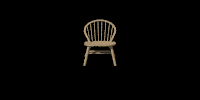

In [0]:
# Load first image for viewing
image1 = image.load_img('/content/drive/My Drive/Colab Notebooks/4) Background Pictures/ws_chair_background00.png', grayscale=False)
image1

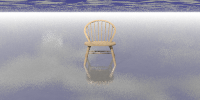

In [0]:
# Load last image for viewing
image1 = image.load_img('/content/drive/My Drive/Colab Notebooks/4) Background Pictures/ws_chair_background35.png', grayscale=False)
image1

In [0]:
# Training Set
# To split the data to train 7 models, such that later models have more exposure to more data
# The pictures are NOT to be shuffled, the pictures are modified with increasing variance (in terms of rotation)
# The rotation is only done in one direction, therefore pictures that are the same (rotated 180 degrees) will be removed

# Model 1: Only the original unmodified image (001)
# Model 2: 000 ~ 06
# Model 3: 000 ~ 12
# Model 4: 000 ~ 18
# Model 5: 000 ~ 24
# Model 6: 000 ~ 30 # Leave out last 6
# Model 7: 34 ~ 35

# Test Set
# All models are tested on the entire dataset of 36

In [0]:
# Data input
# Read in the training images
# Values are in RGB from 0 to 255, divide by 255 to get values from 0 to 1

train_image = []
for i in tqdm(range(0,36)):
    if i < 10:
      stringIndex = "0" + str(i)
    else:
      stringIndex = str(i)

    # Parameter if needed: target_size = rescaled_size
    img = image.load_img('/content/drive/My Drive/Colab Notebooks/4) Background Pictures/ws_chair_background' + stringIndex + '.png', grayscale=False)

    img = image.img_to_array(img)
    img = img/255 
    train_image.append(img)

print(len(train_image))
#X = np.array(train_image) # wait for train face image below

100%|██████████| 36/36 [00:00<00:00, 813.99it/s]

36


In [0]:
X = np.array(train_image) # Transfer

# Create y values for training data
# All are 1s, since all are pictures of target chair
y = [1] * 36
y = np.asarray(y)

print(type(X))
print(X.shape)
print(len(X)) # Total length should be 921 training data

print(type(y))
print(y.shape)
print(len(y)) # Total length should be 921 training data


<class 'numpy.ndarray'>
(36, 100, 200, 3)
36
<class 'numpy.ndarray'>
(36,)
36


In [0]:
print(len(X))
print(X.shape)

print(len(y))
print(y.shape)

36
(36, 100, 200, 3)
36
(36,)


In [0]:
# Split into 6 portions, with the rest as validation sets
X_train1 = X[0:1]
X_train2 = X[0:6]
X_train3 = X[0:12]
X_train4 = X[0:18]
X_train5 = X[0:24]
X_train6 = X[0:30] # Remove last 5 images to set as validation
X_train7 = X[34:36] # Trained on the last 2 images only
# Note: Background data is not necessarily in strict increasing variance magnitude, subjective.
# However the first 25 pictures are the chair with another non-relevant object
# The last 10 pictures are the chair with a non-relevant background

X_train1_flatten = X_train1.reshape(1,flatten_value, 3)
X_train2_flatten = X_train2.reshape(len(X_train2),flatten_value, 3)
X_train3_flatten = X_train3.reshape(len(X_train3),flatten_value, 3)
X_train4_flatten = X_train4.reshape(len(X_train4),flatten_value, 3)
X_train5_flatten = X_train5.reshape(len(X_train5),flatten_value, 3)
X_train6_flatten = X_train6.reshape(len(X_train6),flatten_value, 3)
X_train7_flatten = X_train7.reshape(len(X_train7),flatten_value, 3)

y_train1 = y[0:1]
y_train2 = y[0:6]
y_train3 = y[0:12]
y_train4 = y[0:18]
y_train5 = y[0:24]
y_train6 = y[0:30]
y_train7 = y[34:36]

X_val1 = X[1:36]
X_val2 = X[6:36]
X_val3 = X[12:36]
X_val4 = X[18:36]
X_val5 = X[24:36]
X_val6 = X[30:36]
X_val7 = X[0:34]

X_val1_flatten = X_val1.reshape(len(X_val1),flatten_value, 3)
X_val2_flatten = X_val2.reshape(len(X_val2),flatten_value, 3)
X_val3_flatten = X_val3.reshape(len(X_val3),flatten_value, 3)
X_val4_flatten = X_val4.reshape(len(X_val4),flatten_value, 3)
X_val5_flatten = X_val5.reshape(len(X_val5),flatten_value, 3)
X_val6_flatten = X_val6.reshape(len(X_val6),flatten_value, 3)
X_val7_flatten = X_val7.reshape(len(X_val7),flatten_value, 3)

y_val1 = y[1:36]
y_val2 = y[6:36]
y_val3 = y[12:36]
y_val4 = y[18:36]
y_val5 = y[24:36]
y_val6 = y[30:36]
y_val7 = y[0:34]

print("X Length")
print(len(X))

print("X Train Length")
print(len(X_train1))
print(len(X_train2))
print(len(X_train3))
print(len(X_train4))
print(len(X_train5))
print(len(X_train6))
print(len(X_train7))

print("X_train shape")
print(X_train1.shape)
print(X_train2.shape)
print(X_train3.shape)
print(X_train4.shape)
print(X_train5.shape)
print(X_train6.shape)
print(X_train7.shape)

print("X_train flatten")
print(X_train1_flatten.shape)
print(X_train2_flatten.shape)
print(X_train3_flatten.shape)
print(X_train4_flatten.shape)
print(X_train5_flatten.shape)
print(X_train6_flatten.shape)
print(X_train7_flatten.shape)

print("X_val shape")
print(X_val1.shape)
print(X_val2.shape)
print(X_val3.shape)
print(X_val4.shape)
print(X_val5.shape)
print(X_val6.shape)
print(X_val7.shape)

print("X_val flatten")
print(X_val1_flatten.shape)
print(X_val2_flatten.shape)
print(X_val3_flatten.shape)
print(X_val4_flatten.shape)
print(X_val5_flatten.shape)
print(X_val6_flatten.shape)
print(X_val7_flatten.shape)

print("Data Prepared")

X Length
36
X Train Length
1
6
12
18
24
30
2
X_train shape
(1, 100, 200, 3)
(6, 100, 200, 3)
(12, 100, 200, 3)
(18, 100, 200, 3)
(24, 100, 200, 3)
(30, 100, 200, 3)
(2, 100, 200, 3)
X_train flatten
(1, 20000, 3)
(6, 20000, 3)
(12, 20000, 3)
(18, 20000, 3)
(24, 20000, 3)
(30, 20000, 3)
(2, 20000, 3)
X_val shape
(35, 100, 200, 3)
(30, 100, 200, 3)
(24, 100, 200, 3)
(18, 100, 200, 3)
(12, 100, 200, 3)
(6, 100, 200, 3)
(34, 100, 200, 3)
X_val flatten
(35, 20000, 3)
(30, 20000, 3)
(24, 20000, 3)
(18, 20000, 3)
(12, 20000, 3)
(6, 20000, 3)
(34, 20000, 3)
Data Prepared


In [0]:
print("y_train")
print(y_train1.shape)
print(y_train2.shape)
print(y_train3.shape)
print(y_train4.shape)
print(y_train5.shape)
print(y_train6.shape)
print(y_train7.shape)

print("y_val")
print(y_val1.shape)
print(y_val2.shape)
print(y_val3.shape)
print(y_val4.shape)
print(y_val5.shape)
print(y_val6.shape)
print(y_val7.shape)

y_train
(1,)
(6,)
(12,)
(18,)
(24,)
(30,)
(2,)
y_val
(35,)
(30,)
(24,)
(18,)
(12,)
(6,)
(34,)


In [0]:
# Clear Variables no longer needed
train_image = None
X = None
y = None

In [0]:
###########################################################################################################################
#------------------------------------------------------------Model Building-----------------------------------------------#
###########################################################################################################################

In [0]:
# User defined parameters
batch_size_user = 2
epoch_user = 1
times_to_loop_model = 3

print("User defined parameters set")
print(batch_size_user)
print(epoch_user)
print(times_to_loop_model)

User defined parameters set
2
1
3


In [0]:
###########################################################################################################################
#------------------------------------------------------------Dense Model-----------------------------------------------#
###########################################################################################################################





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 60000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 120002    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 120,011
Trainable params: 120,011
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1 samples, validate on 35 samples
Epoch 1/1





1/1 [==============================] - 10s 10s/step - loss: 0.6931 - ac

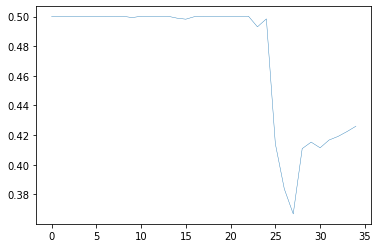

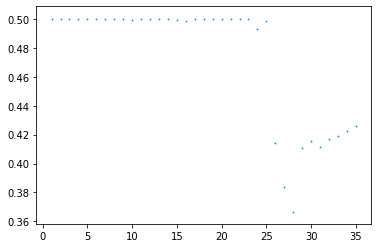

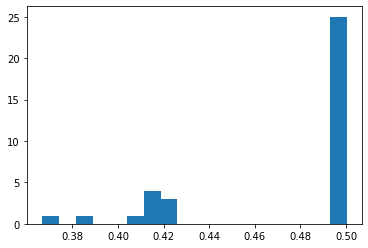

Average value is:  0.4736866
Total Predicted Positive:  25  out of  35
71.42857142857143 %
Epoch:  2
Train on 1 samples, validate on 35 samples
Epoch 1/1
1/1 [==============================] - 0s 45ms/step - loss: 0.6926 - acc: 1.0000 - val_loss: 0.7510 - val_acc: 0.5714
(35, 1)


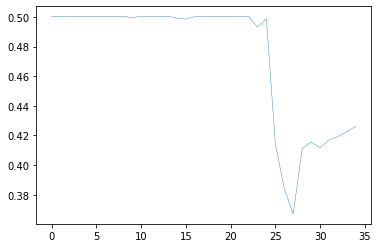

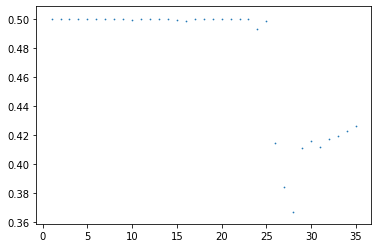

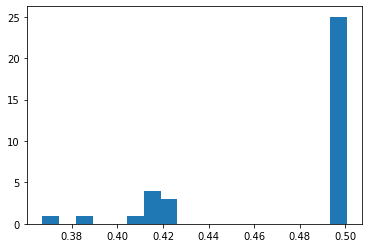

Average value is:  0.4739341
Total Predicted Positive:  25  out of  35
71.42857142857143 %
Epoch:  3
Train on 1 samples, validate on 35 samples
Epoch 1/1
1/1 [==============================] - 0s 45ms/step - loss: 0.6921 - acc: 1.0000 - val_loss: 0.7504 - val_acc: 0.5714
(35, 1)


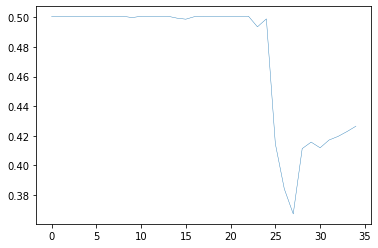

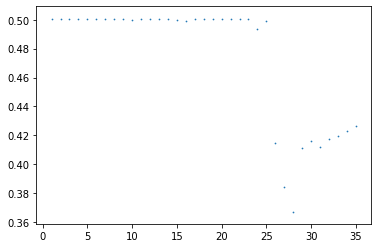

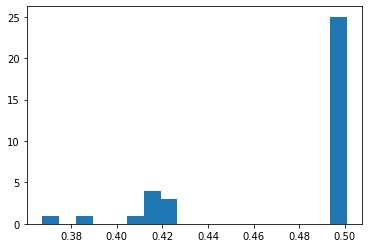

Average value is:  0.4741816
Total Predicted Positive:  25  out of  35
71.42857142857143 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## Dense Model 1
## create the model
modelDense1 = 0
modelDense1 = Sequential()
modelDense1.add(Flatten())
modelDense1.add(Dense(2, activation='relu'))
modelDense1.add(Dense(2, activation='relu'))
modelDense1.add(Dense(1, activation='sigmoid'))
modelDense1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelDense1.build(input_shape) # `input_shape` is the shape of the input data

print(modelDense1.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelDense1.fit(X_train1, y_train1, epochs=1, batch_size=batch_size_user, validation_data = (X_val1, y_val1),verbose=1)

  # Test the model
  y_pred = modelDense1.predict(X_val1)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 60000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 120002    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 3         
Total params: 120,011
Trainable params: 120,011
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 6 samples, validate on 30 samples
Epoch 1/1
6/6 [==============================] - 0s 52ms/step - loss: 0.6928 - acc: 0.6667 - val_loss: 0.7605 - val_acc: 0.5000
(30, 1)


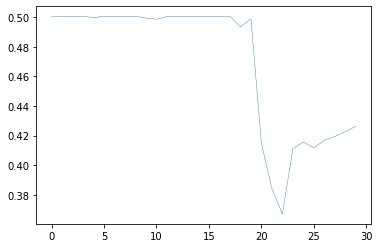

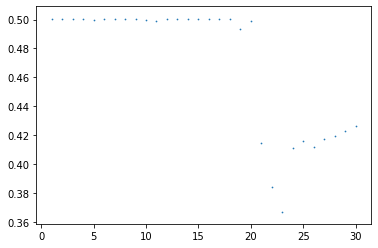

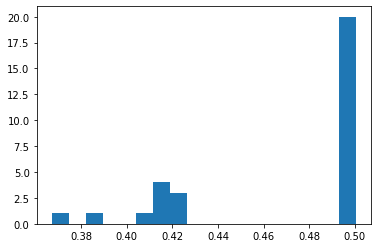

Average value is:  0.4696331
Total Predicted Positive:  20  out of  30
66.66666666666666 %
Epoch:  2
Train on 6 samples, validate on 30 samples
Epoch 1/1
6/6 [==============================] - 0s 8ms/step - loss: 0.6914 - acc: 1.0000 - val_loss: 0.7590 - val_acc: 0.5667
(30, 1)


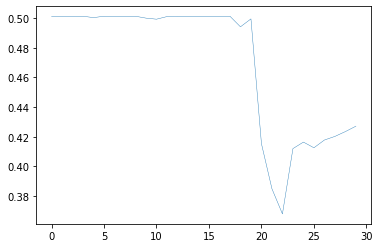

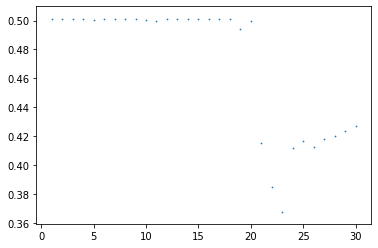

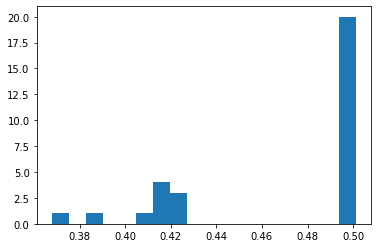

Average value is:  0.4703413
Total Predicted Positive:  20  out of  30
66.66666666666666 %
Epoch:  3
Train on 6 samples, validate on 30 samples
Epoch 1/1
6/6 [==============================] - 0s 7ms/step - loss: 0.6900 - acc: 1.0000 - val_loss: 0.7574 - val_acc: 0.6333
(30, 1)


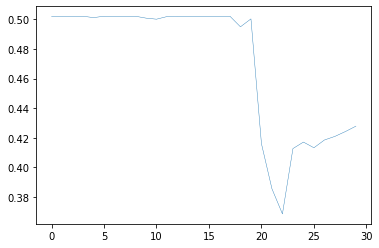

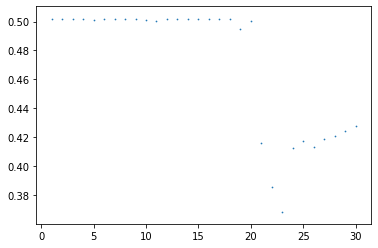

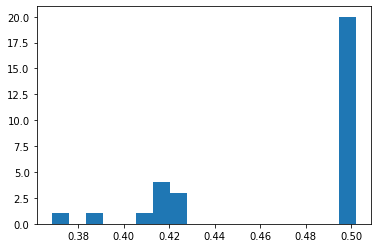

Average value is:  0.47107175
Total Predicted Positive:  20  out of  30
66.66666666666666 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## Dense Model 2
## create the model
modelDense2 = 0
modelDense2 = Sequential()
modelDense2.add(Flatten())
modelDense2.add(Dense(2, activation='relu'))
modelDense2.add(Dense(2, activation='relu'))
modelDense2.add(Dense(1, activation='sigmoid'))
modelDense2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelDense2.build(input_shape) # `input_shape` is the shape of the input data

print(modelDense2.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelDense2.fit(X_train2, y_train2, epochs=1, batch_size=batch_size_user, validation_data = (X_val2, y_val2),verbose=1)

  # Test the model
  y_pred = modelDense2.predict(X_val2)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 60000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 120002    
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 3         
Total params: 120,011
Trainable params: 120,011
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 12 samples, validate on 24 samples
Epoch 1/1
12/12 [==============================] - 0s 30ms/step - loss: 0.6920 - acc: 0.8333 - val_loss: 0.6974 - val_acc: 0.7083
(24, 1)


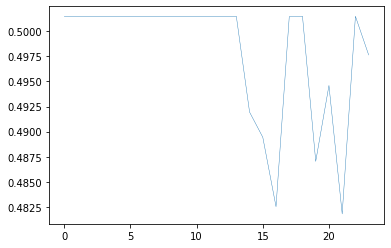

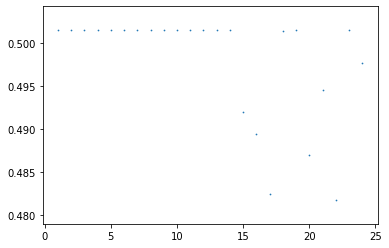

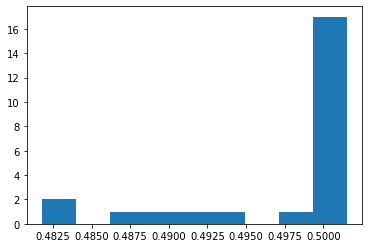

Average value is:  0.49793562
Total Predicted Positive:  17  out of  24
70.83333333333334 %
Epoch:  2
Train on 12 samples, validate on 24 samples
Epoch 1/1
12/12 [==============================] - 0s 4ms/step - loss: 0.6889 - acc: 1.0000 - val_loss: 0.6943 - val_acc: 0.7083
(24, 1)


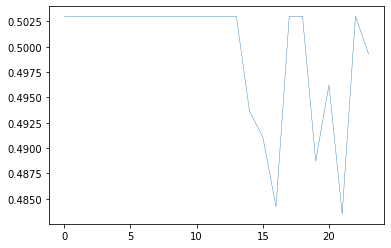

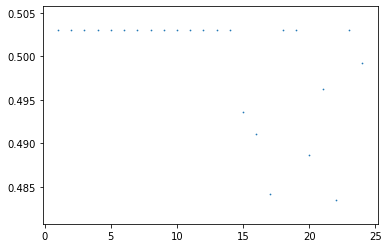

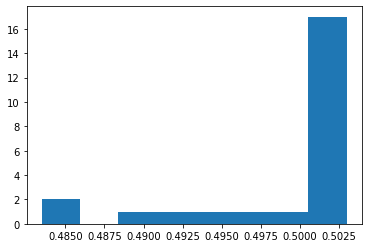

Average value is:  0.49948552
Total Predicted Positive:  17  out of  24
70.83333333333334 %
Epoch:  3
Train on 12 samples, validate on 24 samples
Epoch 1/1
12/12 [==============================] - 0s 5ms/step - loss: 0.6859 - acc: 1.0000 - val_loss: 0.6912 - val_acc: 0.7500
(24, 1)


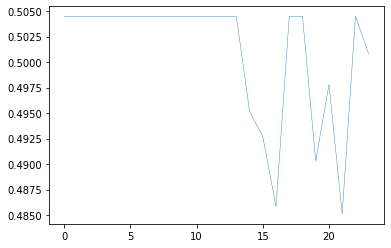

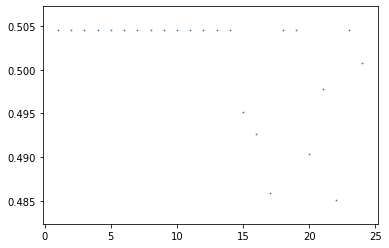

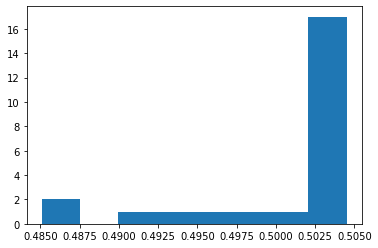

Average value is:  0.50100946
Total Predicted Positive:  17  out of  24
70.83333333333334 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## Dense Model 3
## create the model
modelDense3 = 0
modelDense3 = Sequential()
modelDense3.add(Flatten())
modelDense3.add(Dense(2, activation='relu'))
modelDense3.add(Dense(2, activation='relu'))
modelDense3.add(Dense(1, activation='sigmoid'))
modelDense3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelDense3.build(input_shape) # `input_shape` is the shape of the input data

print(modelDense3.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelDense3.fit(X_train3, y_train3, epochs=1, batch_size=batch_size_user, validation_data = (X_val3, y_val3),verbose=1)

  # Test the model
  y_pred = modelDense3.predict(X_val3)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 60000)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 120002    
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 3         
Total params: 120,011
Trainable params: 120,011
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 18 samples, validate on 18 samples
Epoch 1/1
18/18 [==============================] - 0s 22ms/step - loss: 0.6913 - acc: 0.8333 - val_loss: 0.6982 - val_acc: 0.6111
(18, 1)


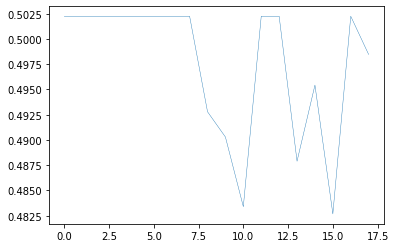

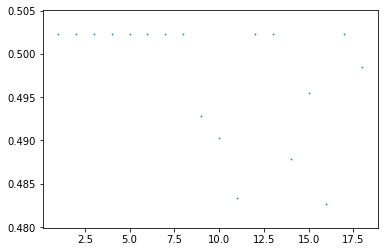

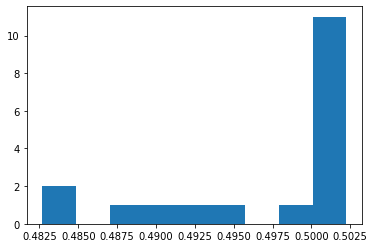

Average value is:  0.49753782
Total Predicted Positive:  12  out of  18
66.66666666666666 %
Epoch:  2
Train on 18 samples, validate on 18 samples
Epoch 1/1
18/18 [==============================] - 0s 3ms/step - loss: 0.6867 - acc: 1.0000 - val_loss: 0.6935 - val_acc: 0.6667
(18, 1)


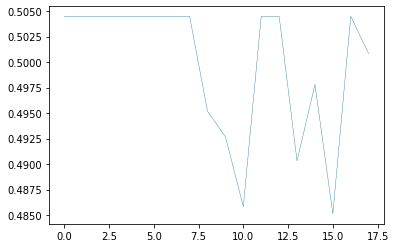

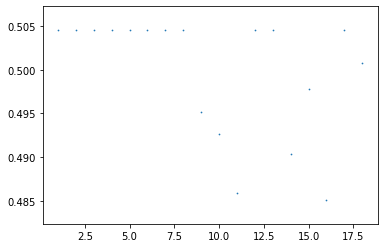

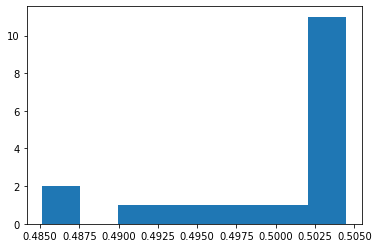

Average value is:  0.49984688
Total Predicted Positive:  12  out of  18
66.66666666666666 %
Epoch:  3
Train on 18 samples, validate on 18 samples
Epoch 1/1
18/18 [==============================] - 0s 4ms/step - loss: 0.6822 - acc: 1.0000 - val_loss: 0.6890 - val_acc: 0.7222
(18, 1)


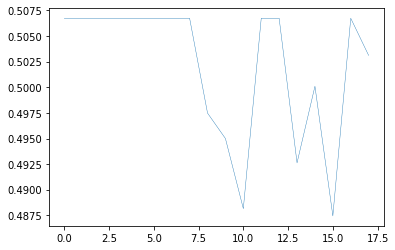

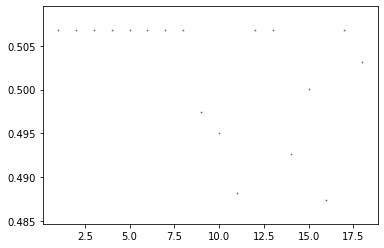

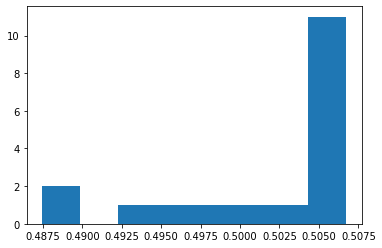

Average value is:  0.5021171
Total Predicted Positive:  12  out of  18
66.66666666666666 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## Dense Model 4
## create the model
modelDense4 = 0
modelDense4 = Sequential()
modelDense4.add(Flatten())
modelDense4.add(Dense(2, activation='relu'))
modelDense4.add(Dense(2, activation='relu'))
modelDense4.add(Dense(1, activation='sigmoid'))
modelDense4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelDense4.build(input_shape) # `input_shape` is the shape of the input data

print(modelDense4.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelDense4.fit(X_train4, y_train4, epochs=1, batch_size=batch_size_user, validation_data = (X_val4, y_val4),verbose=1)

  # Test the model
  y_pred = modelDense4.predict(X_val4)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 60000)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 120002    
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 3         
Total params: 120,011
Trainable params: 120,011
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 24 samples, validate on 12 samples
Epoch 1/1
24/24 [==============================] - 0s 18ms/step - loss: 0.6904 - acc: 0.9167 - val_loss: 0.7013 - val_acc: 0.4167
(12, 1)


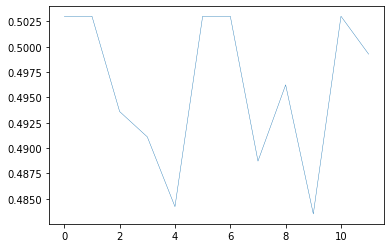

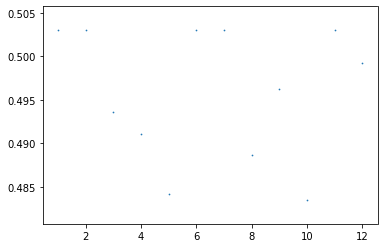

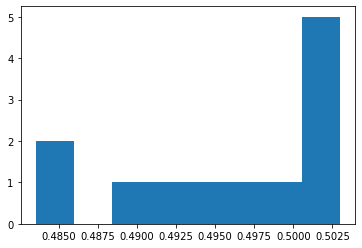

Average value is:  0.4959718
Total Predicted Positive:  7  out of  12
58.333333333333336 %
Epoch:  2
Train on 24 samples, validate on 12 samples
Epoch 1/1
24/24 [==============================] - 0s 2ms/step - loss: 0.6844 - acc: 1.0000 - val_loss: 0.6952 - val_acc: 0.5000
(12, 1)


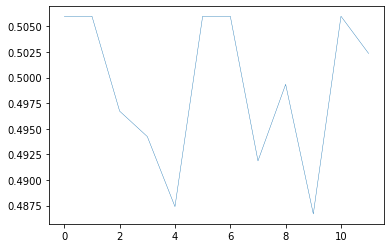

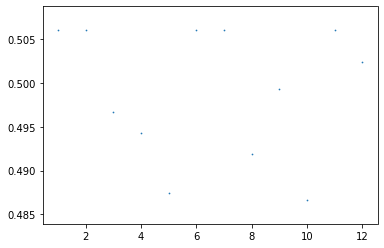

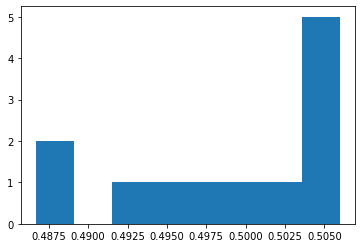

Average value is:  0.49904716
Total Predicted Positive:  7  out of  12
58.333333333333336 %
Epoch:  3
Train on 24 samples, validate on 12 samples
Epoch 1/1
24/24 [==============================] - 0s 2ms/step - loss: 0.6785 - acc: 1.0000 - val_loss: 0.6891 - val_acc: 0.5833
(12, 1)


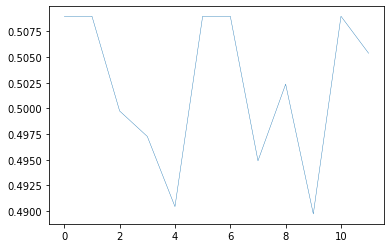

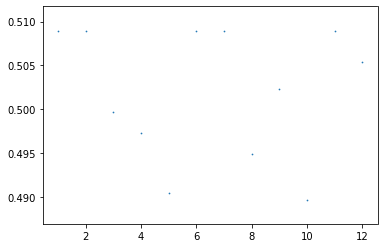

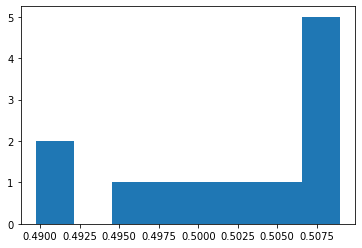

Average value is:  0.50206167
Total Predicted Positive:  7  out of  12
58.333333333333336 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## Dense Model 5
## create the model
modelDense5 = 0
modelDense5 = Sequential()
modelDense5.add(Flatten())
modelDense5.add(Dense(2, activation='relu'))
modelDense5.add(Dense(2, activation='relu'))
modelDense5.add(Dense(1, activation='sigmoid'))
modelDense5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelDense5.build(input_shape) # `input_shape` is the shape of the input data

print(modelDense5.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelDense5.fit(X_train5, y_train5, epochs=1, batch_size=batch_size_user, validation_data = (X_val5, y_val5),verbose=1)

  # Test the model
  y_pred = modelDense5.predict(X_val5)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 60000)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 120002    
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 3         
Total params: 120,011
Trainable params: 120,011
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 30 samples, validate on 6 samples
Epoch 1/1
30/30 [==============================] - 1s 18ms/step - loss: 0.6903 - acc: 0.9000 - val_loss: 0.6857 - val_acc: 1.0000
(6, 1)


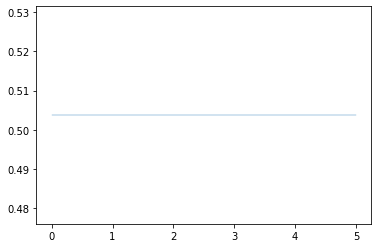

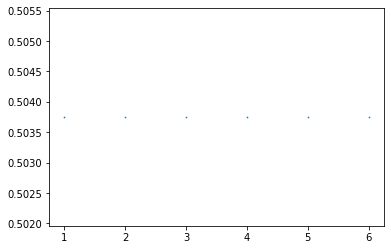

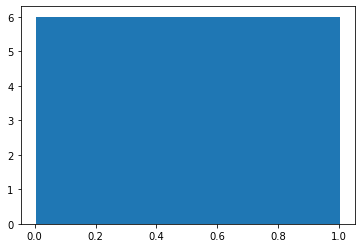

Average value is:  0.50374895
Total Predicted Positive:  6  out of  6
100.0 %
Epoch:  2
Train on 30 samples, validate on 6 samples
Epoch 1/1
30/30 [==============================] - 0s 2ms/step - loss: 0.6822 - acc: 1.0000 - val_loss: 0.6783 - val_acc: 1.0000
(6, 1)


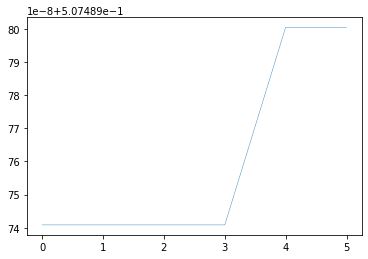

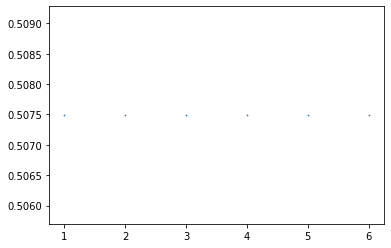

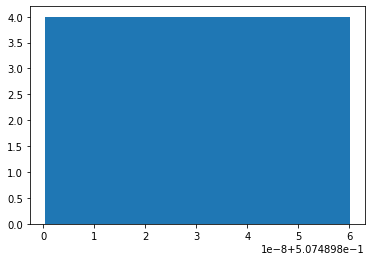

Average value is:  0.50748974
Total Predicted Positive:  6  out of  6
100.0 %
Epoch:  3
Train on 30 samples, validate on 6 samples
Epoch 1/1
30/30 [==============================] - 0s 2ms/step - loss: 0.6749 - acc: 1.0000 - val_loss: 0.6710 - val_acc: 1.0000
(6, 1)


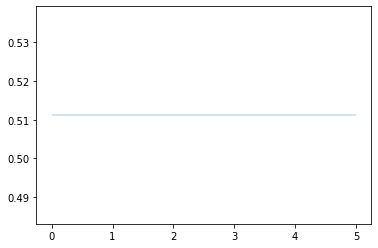

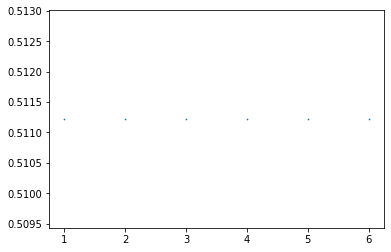

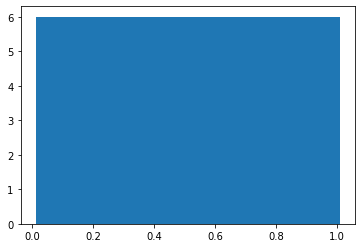

Average value is:  0.5112185
Total Predicted Positive:  6  out of  6
100.0 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## Dense Model 6
## create the model
modelDense6 = 0
modelDense6 = Sequential()
modelDense6.add(Flatten())
modelDense6.add(Dense(2, activation='relu'))
modelDense6.add(Dense(2, activation='relu'))
modelDense6.add(Dense(1, activation='sigmoid'))
modelDense6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelDense6.build(input_shape) # `input_shape` is the shape of the input data

print(modelDense6.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelDense6.fit(X_train6, y_train6, epochs=1, batch_size=batch_size_user, validation_data = (X_val6, y_val6),verbose=1)

  # Test the model
  y_pred = modelDense6.predict(X_val6)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 60000)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 120002    
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 3         
Total params: 120,011
Trainable params: 120,011
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 2 samples, validate on 34 samples
Epoch 1/1
2/2 [==============================] - 1s 258ms/step - loss: 0.8582 - acc: 0.0000e+00 - val_loss: 0.6926 - val_acc: 1.0000
(34, 1)


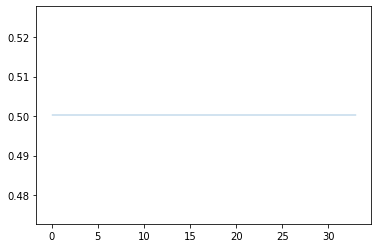

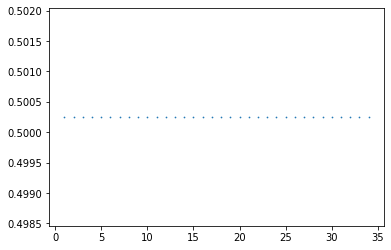

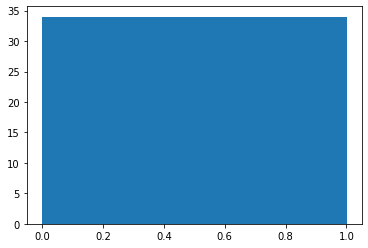

Average value is:  0.50025
Total Predicted Positive:  34  out of  34
100.0 %
Epoch:  2
Train on 2 samples, validate on 34 samples
Epoch 1/1
2/2 [==============================] - 0s 18ms/step - loss: 0.6926 - acc: 1.0000 - val_loss: 0.6922 - val_acc: 1.0000
(34, 1)


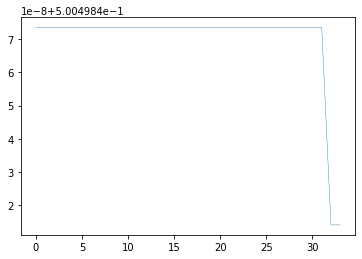

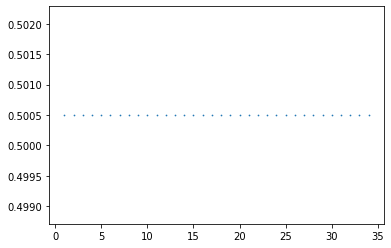

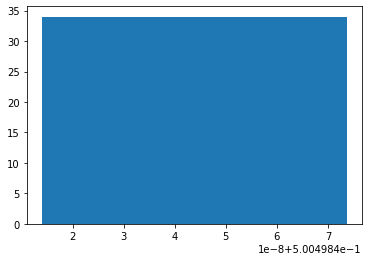

Average value is:  0.5004984
Total Predicted Positive:  34  out of  34
100.0 %
Epoch:  3
Train on 2 samples, validate on 34 samples
Epoch 1/1
2/2 [==============================] - 0s 17ms/step - loss: 0.6922 - acc: 1.0000 - val_loss: 0.6917 - val_acc: 1.0000
(34, 1)


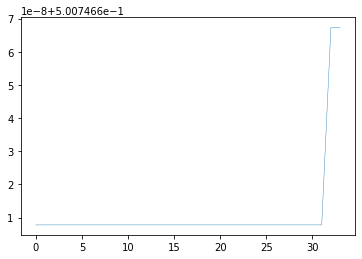

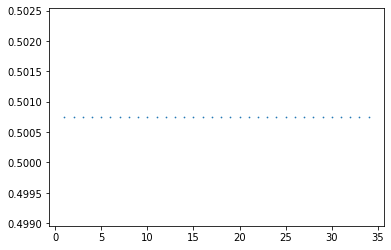

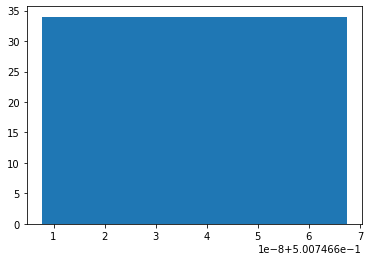

Average value is:  0.50074655
Total Predicted Positive:  34  out of  34
100.0 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## Dense Model 7
## create the model
modelDense7 = 0
modelDense7 = Sequential()
modelDense7.add(Flatten())
modelDense7.add(Dense(2, activation='relu'))
modelDense7.add(Dense(2, activation='relu'))
modelDense7.add(Dense(1, activation='sigmoid'))
modelDense7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelDense7.build(input_shape) # `input_shape` is the shape of the input data

print(modelDense7.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelDense7.fit(X_train7, y_train7, epochs=1, batch_size=batch_size_user, validation_data = (X_val7, y_val7),verbose=1)

  # Test the model
  y_pred = modelDense7.predict(X_val7)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1

In [0]:
###########################################################################################################################
#------------------------------------------------------------CNN Model-----------------------------------------------#
###########################################################################################################################


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 99, 199, 4)        52        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 99, 4)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 19404)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 19405     
Total params: 19,457
Trainable params: 19,457
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 1 samples, validate on 35 samples
Epoch 1/1
1/1 [==============================] - 6s 6s/step - loss: 0.6687 - acc: 1.0000 - val_loss: 0.5128 - val_acc: 1.0000
(35, 1)


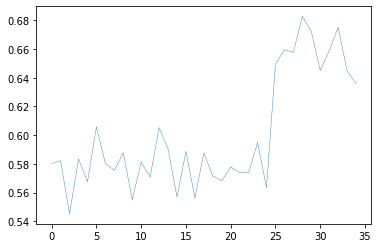

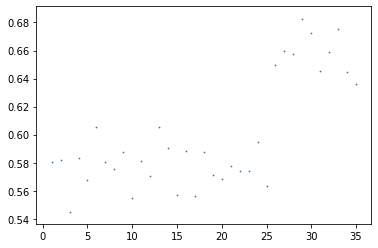

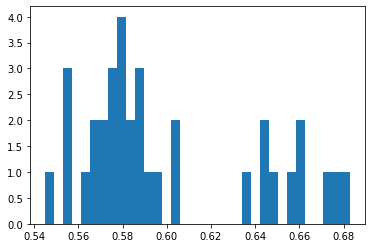

Average value is:  0.6001002
Total Predicted Positive:  12  out of  35
34.285714285714285 %
Epoch:  2
Train on 1 samples, validate on 35 samples
Epoch 1/1
1/1 [==============================] - 0s 46ms/step - loss: 0.5636 - acc: 1.0000 - val_loss: 0.3007 - val_acc: 1.0000
(35, 1)


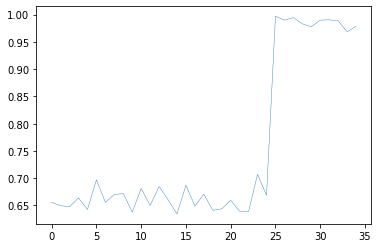

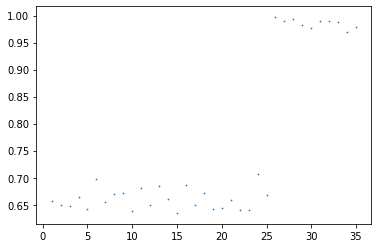

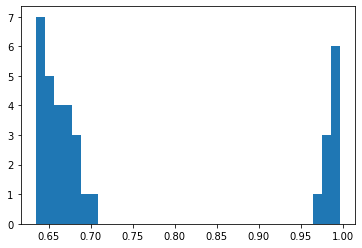

Average value is:  0.7534023
Total Predicted Positive:  10  out of  35
28.57142857142857 %
Epoch:  3
Train on 1 samples, validate on 35 samples
Epoch 1/1
1/1 [==============================] - 0s 50ms/step - loss: 0.4670 - acc: 1.0000 - val_loss: 0.2146 - val_acc: 1.0000
(35, 1)


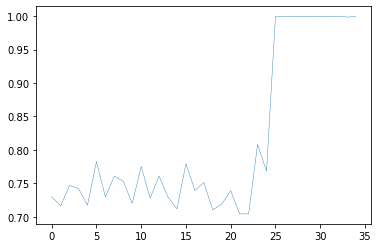

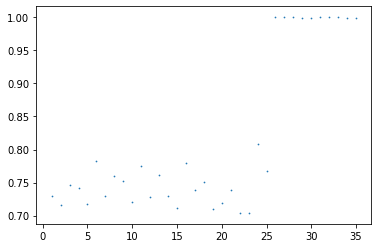

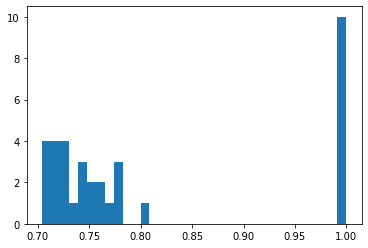

Average value is:  0.81493115
Total Predicted Positive:  10  out of  35
28.57142857142857 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## CNN Model 1
## create the model
modelCNN1 = 0
modelCNN1 = Sequential()
modelCNN1.add(Conv2D(4, kernel_size=(2, 2),activation='relu'))
modelCNN1.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN1.add(Flatten())
modelCNN1.add(Dense(1, activation='sigmoid'))
modelCNN1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelCNN1.build(input_shape) # `input_shape` is the shape of the input data

print(modelCNN1.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelCNN1.fit(X_train1, y_train1, epochs=1, batch_size=batch_size_user, validation_data = (X_val1, y_val1),verbose=1)

  # Test the model
  y_pred = modelCNN1.predict(X_val1)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 99, 199, 4)        52        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 49, 99, 4)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 19404)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 19405     
Total params: 19,457
Trainable params: 19,457
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 6 samples, validate on 30 samples
Epoch 1/1
6/6 [==============================] - 1s 135ms/step - loss: 0.5423 - acc: 1.0000 - val_loss: 0.2026 - val_acc: 1.0000
(30, 1)


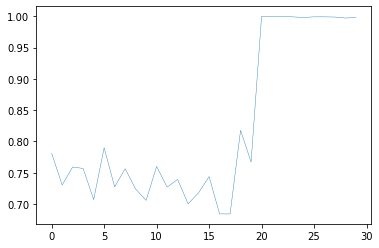

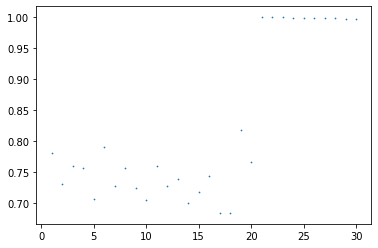

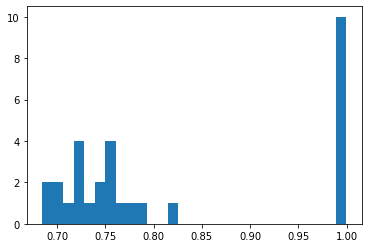

Average value is:  0.8256846
Total Predicted Positive:  10  out of  30
33.33333333333333 %
Epoch:  2
Train on 6 samples, validate on 30 samples
Epoch 1/1
6/6 [==============================] - 0s 7ms/step - loss: 0.2521 - acc: 1.0000 - val_loss: 0.0664 - val_acc: 1.0000
(30, 1)


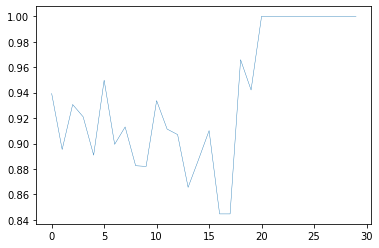

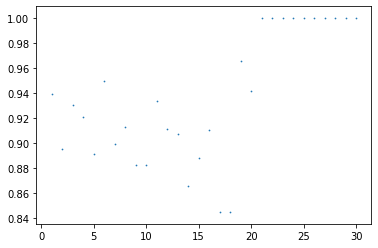

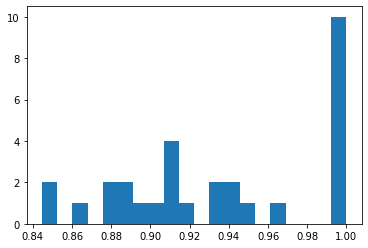

Average value is:  0.9372243
Total Predicted Positive:  14  out of  30
46.666666666666664 %
Epoch:  3
Train on 6 samples, validate on 30 samples
Epoch 1/1
6/6 [==============================] - 0s 7ms/step - loss: 0.0963 - acc: 1.0000 - val_loss: 0.0184 - val_acc: 1.0000
(30, 1)


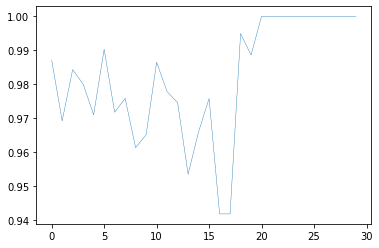

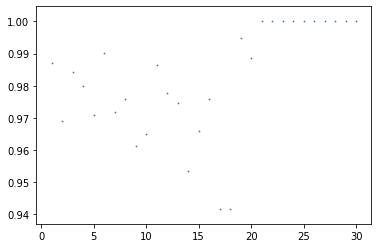

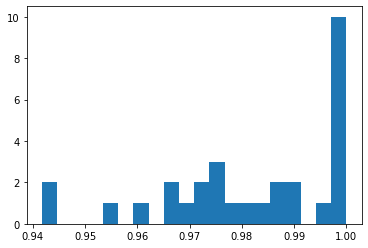

Average value is:  0.98189557
Total Predicted Positive:  16  out of  30
53.333333333333336 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## CNN Model 2
## create the model
modelCNN2 = 0
modelCNN2 = Sequential()
modelCNN2.add(Conv2D(4, kernel_size=(2, 2),activation='relu'))
modelCNN2.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN2.add(Flatten())
modelCNN2.add(Dense(1, activation='sigmoid'))
modelCNN2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelCNN2.build(input_shape) # `input_shape` is the shape of the input data

print(modelCNN2.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelCNN2.fit(X_train2, y_train2, epochs=1, batch_size=batch_size_user, validation_data = (X_val2, y_val2),verbose=1)

  # Test the model
  y_pred = modelCNN2.predict(X_val2)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 99, 199, 4)        52        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 49, 99, 4)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 19404)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 19405     
Total params: 19,457
Trainable params: 19,457
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 12 samples, validate on 24 samples
Epoch 1/1
12/12 [==============================] - 1s 55ms/step - loss: 0.3445 - acc: 1.0000 - val_loss: 0.0517 - val_acc: 1.0000
(24, 1)


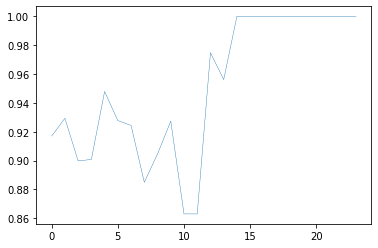

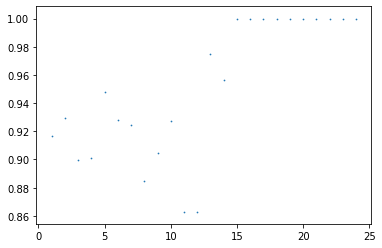

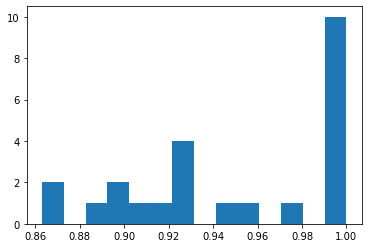

Average value is:  0.95085305
Total Predicted Positive:  12  out of  24
50.0 %
Epoch:  2
Train on 12 samples, validate on 24 samples
Epoch 1/1
12/12 [==============================] - 0s 5ms/step - loss: 0.0405 - acc: 1.0000 - val_loss: 0.0050 - val_acc: 1.0000
(24, 1)


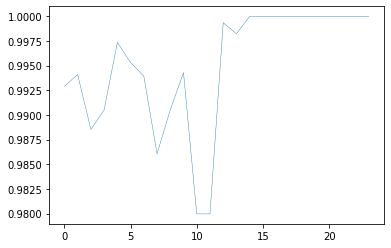

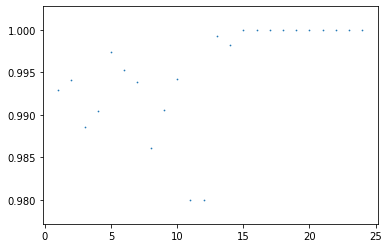

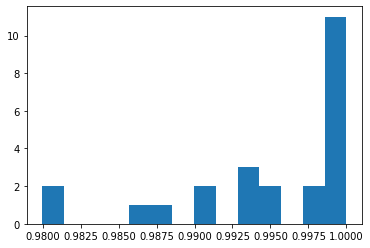

Average value is:  0.99503994
Total Predicted Positive:  14  out of  24
58.333333333333336 %
Epoch:  3
Train on 12 samples, validate on 24 samples
Epoch 1/1
12/12 [==============================] - 0s 5ms/step - loss: 0.0051 - acc: 1.0000 - val_loss: 5.6577e-04 - val_acc: 1.0000
(24, 1)


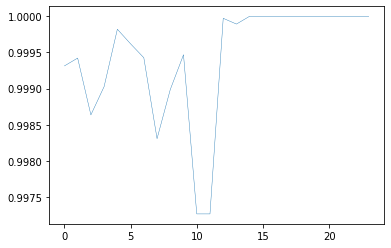

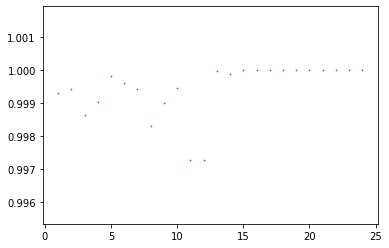

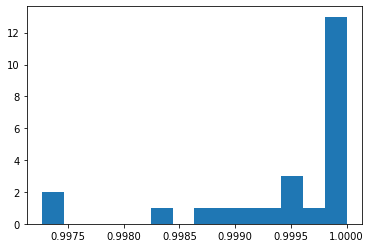

Average value is:  0.9994347
Total Predicted Positive:  15  out of  24
62.5 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## CNN Model 3
## create the model
modelCNN3 = 0
modelCNN3 = Sequential()
modelCNN3.add(Conv2D(4, kernel_size=(2, 2),activation='relu'))
modelCNN3.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN3.add(Flatten())
modelCNN3.add(Dense(1, activation='sigmoid'))
modelCNN3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelCNN3.build(input_shape) # `input_shape` is the shape of the input data

print(modelCNN3.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelCNN3.fit(X_train3, y_train3, epochs=1, batch_size=batch_size_user, validation_data = (X_val3, y_val3),verbose=1)

  # Test the model
  y_pred = modelCNN3.predict(X_val3)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 99, 199, 4)        52        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 49, 99, 4)         0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 19404)             0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 19405     
Total params: 19,457
Trainable params: 19,457
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 18 samples, validate on 18 samples
Epoch 1/1
18/18 [==============================] - 1s 39ms/step - loss: 0.2500 - acc: 1.0000 - val_loss: 0.0121 - val_acc: 1.0000
(18, 1)


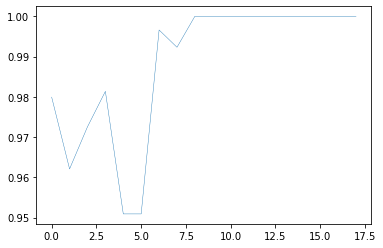

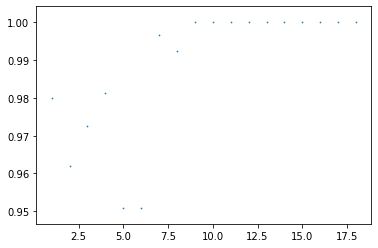

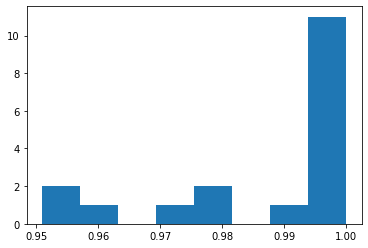

Average value is:  0.98814654
Total Predicted Positive:  12  out of  18
66.66666666666666 %
Epoch:  2
Train on 18 samples, validate on 18 samples
Epoch 1/1
18/18 [==============================] - 0s 3ms/step - loss: 0.0078 - acc: 1.0000 - val_loss: 4.9257e-04 - val_acc: 1.0000
(18, 1)


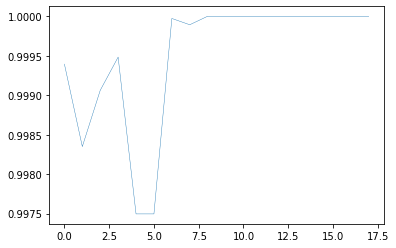

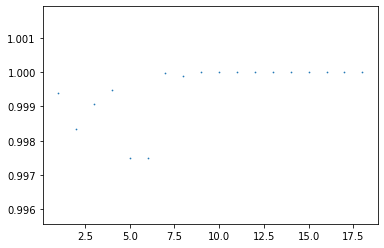

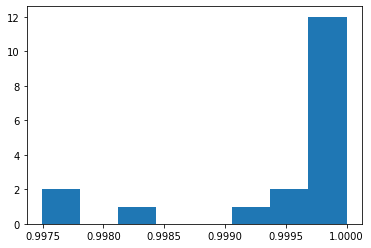

Average value is:  0.999508
Total Predicted Positive:  12  out of  18
66.66666666666666 %
Epoch:  3
Train on 18 samples, validate on 18 samples
Epoch 1/1
18/18 [==============================] - 0s 3ms/step - loss: 5.3327e-04 - acc: 1.0000 - val_loss: 6.0159e-05 - val_acc: 1.0000
(18, 1)


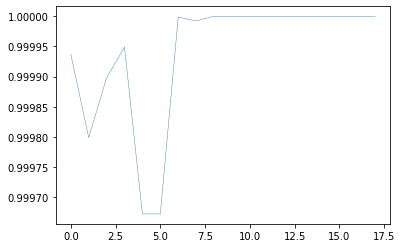

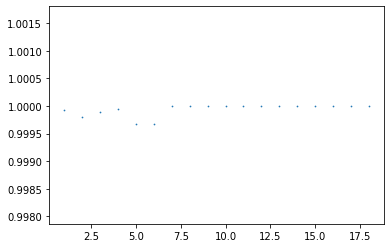

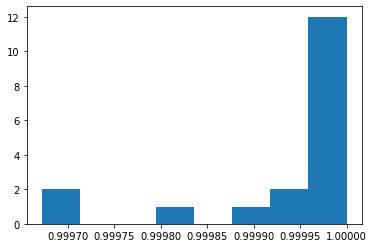

Average value is:  0.9999399
Total Predicted Positive:  13  out of  18
72.22222222222221 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## CNN Model 4
## create the model
modelCNN4 = 0
modelCNN4 = Sequential()
modelCNN4.add(Conv2D(4, kernel_size=(2, 2),activation='relu'))
modelCNN4.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN4.add(Flatten())
modelCNN4.add(Dense(1, activation='sigmoid'))
modelCNN4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelCNN4.build(input_shape) # `input_shape` is the shape of the input data

print(modelCNN4.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelCNN4.fit(X_train4, y_train4, epochs=1, batch_size=batch_size_user, validation_data = (X_val4, y_val4),verbose=1)

  # Test the model
  y_pred = modelCNN4.predict(X_val4)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 99, 199, 4)        52        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 49, 99, 4)         0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 19404)             0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 19405     
Total params: 19,457
Trainable params: 19,457
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 24 samples, validate on 12 samples
Epoch 1/1
24/24 [==============================] - 1s 32ms/step - loss: 0.2073 - acc: 1.0000 - val_loss: 1.7436e-04 - val_acc: 1.0000
(12, 1)


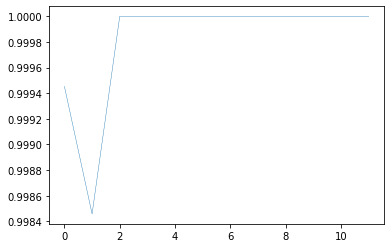

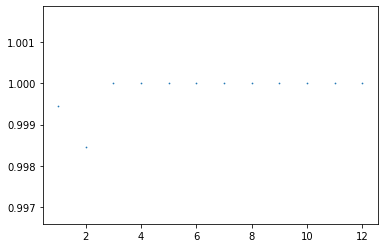

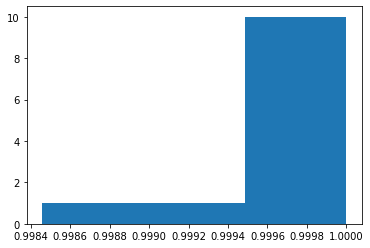

Average value is:  0.9998258
Total Predicted Positive:  10  out of  12
83.33333333333334 %
Epoch:  2
Train on 24 samples, validate on 12 samples
Epoch 1/1
24/24 [==============================] - 0s 3ms/step - loss: 0.0027 - acc: 1.0000 - val_loss: 1.1424e-06 - val_acc: 1.0000
(12, 1)


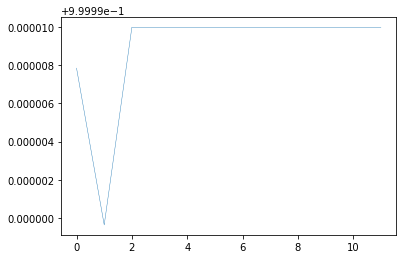

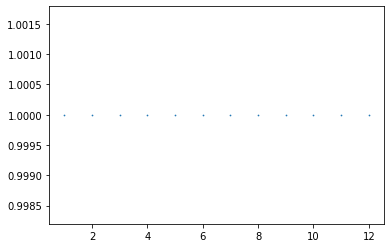

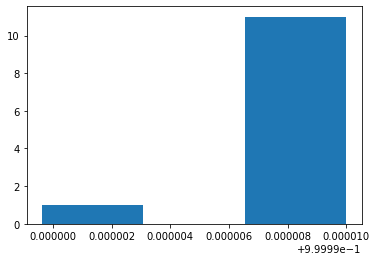

Average value is:  0.999999
Total Predicted Positive:  10  out of  12
83.33333333333334 %
Epoch:  3
Train on 24 samples, validate on 12 samples
Epoch 1/1
24/24 [==============================] - 0s 3ms/step - loss: 7.5333e-05 - acc: 1.0000 - val_loss: 2.2848e-07 - val_acc: 1.0000
(12, 1)


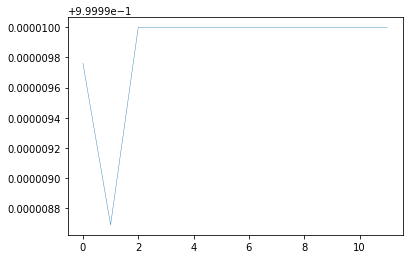

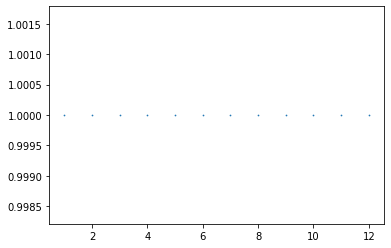

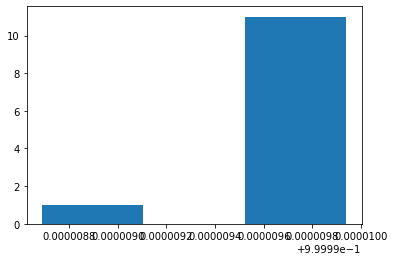

Average value is:  0.9999998
Total Predicted Positive:  10  out of  12
83.33333333333334 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## CNN Model 5
## create the model
modelCNN5 = 0
modelCNN5 = Sequential()
modelCNN5.add(Conv2D(4, kernel_size=(2, 2),activation='relu'))
modelCNN5.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN5.add(Flatten())
modelCNN5.add(Dense(1, activation='sigmoid'))
modelCNN5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelCNN5.build(input_shape) # `input_shape` is the shape of the input data

print(modelCNN5.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelCNN5.fit(X_train5, y_train5, epochs=1, batch_size=batch_size_user, validation_data = (X_val5, y_val5),verbose=1)

  # Test the model
  y_pred = modelCNN5.predict(X_val5)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 99, 199, 4)        52        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 49, 99, 4)         0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 19404)             0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 19405     
Total params: 19,457
Trainable params: 19,457
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 30 samples, validate on 6 samples
Epoch 1/1
30/30 [==============================] - 1s 28ms/step - loss: 0.1512 - acc: 0.9667 - val_loss: 1.1921e-07 - val_acc: 1.0000
(6, 1)


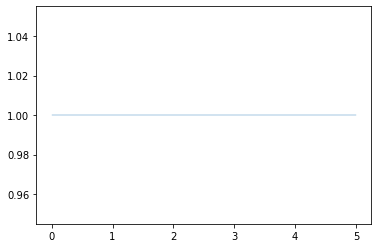

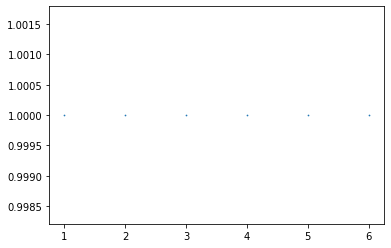

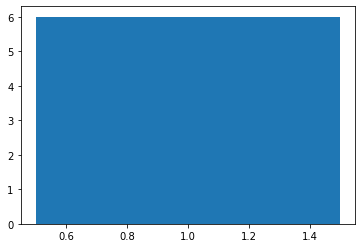

Average value is:  1.0
Total Predicted Positive:  6  out of  6
100.0 %
Epoch:  2
Train on 30 samples, validate on 6 samples
Epoch 1/1
30/30 [==============================] - 0s 2ms/step - loss: 6.7137e-04 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
(6, 1)


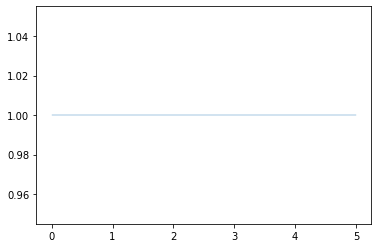

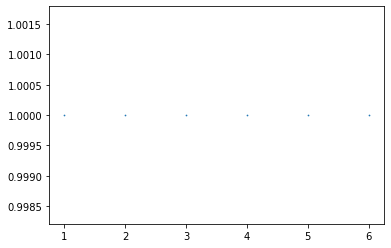

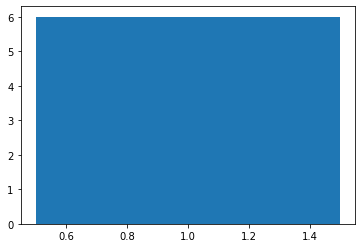

Average value is:  1.0
Total Predicted Positive:  6  out of  6
100.0 %
Epoch:  3
Train on 30 samples, validate on 6 samples
Epoch 1/1
30/30 [==============================] - 0s 2ms/step - loss: 3.0970e-05 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
(6, 1)


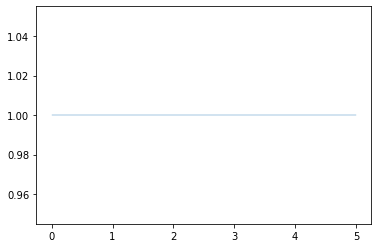

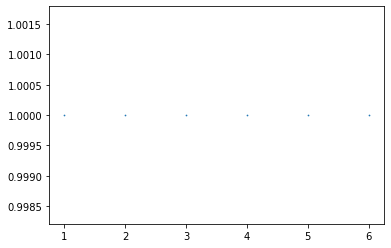

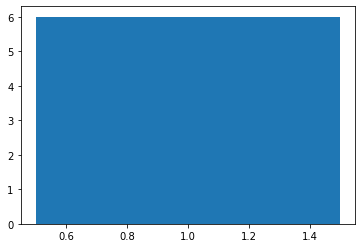

Average value is:  1.0
Total Predicted Positive:  6  out of  6
100.0 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## CNN Model 6
## create the model
modelCNN6 = 0
modelCNN6 = Sequential()
modelCNN6.add(Conv2D(4, kernel_size=(2, 2),activation='relu'))
modelCNN6.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN6.add(Flatten())
modelCNN6.add(Dense(1, activation='sigmoid'))
modelCNN6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelCNN6.build(input_shape) # `input_shape` is the shape of the input data

print(modelCNN6.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelCNN6.fit(X_train6, y_train6, epochs=1, batch_size=batch_size_user, validation_data = (X_val6, y_val6),verbose=1)

  # Test the model
  y_pred = modelCNN6.predict(X_val6)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 99, 199, 4)        52        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 49, 99, 4)         0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 19404)             0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 19405     
Total params: 19,457
Trainable params: 19,457
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 2 samples, validate on 34 samples
Epoch 1/1
2/2 [==============================] - 1s 427ms/step - loss: 0.5818 - acc: 1.0000 - val_loss: 0.3611 - val_acc: 1.0000
(34, 1)


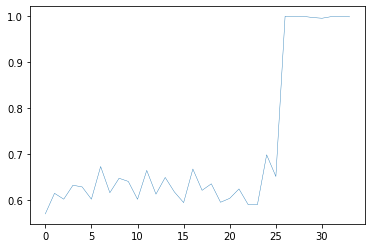

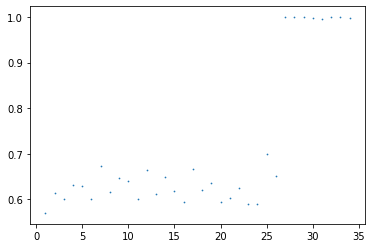

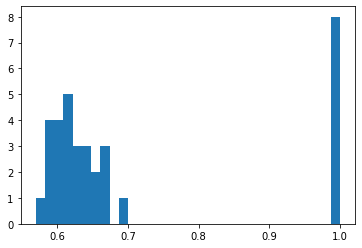

Average value is:  0.7125782
Total Predicted Positive:  8  out of  34
23.52941176470588 %
Epoch:  2
Train on 2 samples, validate on 34 samples
Epoch 1/1
2/2 [==============================] - 0s 24ms/step - loss: 0.0052 - acc: 1.0000 - val_loss: 0.2849 - val_acc: 1.0000
(34, 1)


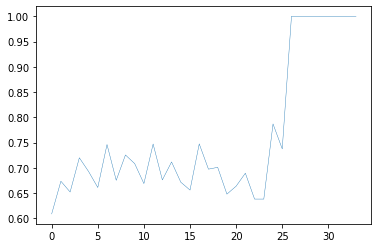

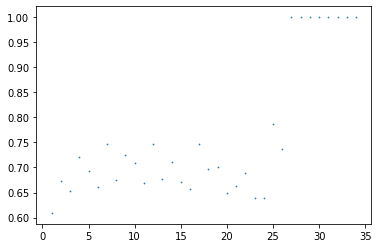

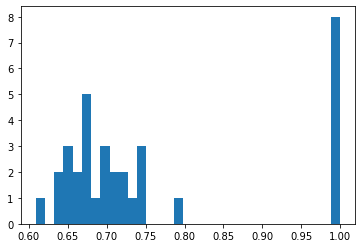

Average value is:  0.7630806
Total Predicted Positive:  9  out of  34
26.47058823529412 %
Epoch:  3
Train on 2 samples, validate on 34 samples
Epoch 1/1
2/2 [==============================] - 0s 21ms/step - loss: 1.9115e-04 - acc: 1.0000 - val_loss: 0.2358 - val_acc: 1.0000
(34, 1)


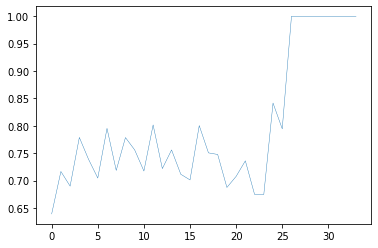

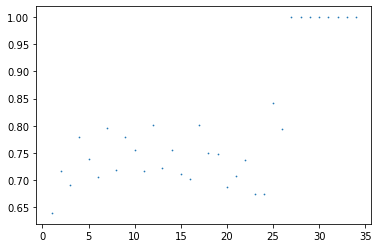

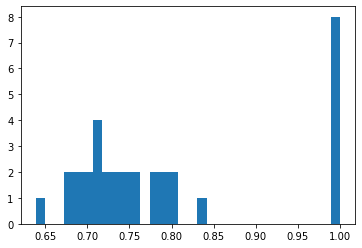

Average value is:  0.79822206
Total Predicted Positive:  11  out of  34
32.35294117647059 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## CNN Model 7
## create the model
modelCNN7 = 0
modelCNN7 = Sequential()
modelCNN7.add(Conv2D(4, kernel_size=(2, 2),activation='relu'))
modelCNN7.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN7.add(Flatten())
modelCNN7.add(Dense(1, activation='sigmoid'))
modelCNN7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelCNN7.build(input_shape) # `input_shape` is the shape of the input data

print(modelCNN7.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelCNN7.fit(X_train7, y_train7, epochs=1, batch_size=batch_size_user, validation_data = (X_val7, y_val7),verbose=1)

  # Test the model
  y_pred = modelCNN7.predict(X_val7)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1

In [0]:
###########################################################################################################################
#------------------------------------------------------------RNN Model-----------------------------------------------#
###########################################################################################################################

In [0]:
# User defined parameters, for RNN particularly
# https://datascience.stackexchange.com/questions/20442/recurrent-neural-network-producing-same-predictions
# Has suggested that increasing batch size will help RNN stop predicting the same value for all
batch_size_user = 150
#epoch_user = 1
#times_to_loop_model = 5

print("User defined parameters set")
print(batch_size_user)
print(epoch_user)
print(times_to_loop_model)

User defined parameters set
150
1
3


In [0]:
print(input_shape)
print(flatten_shape)

(None, 100, 200, 3)
(None, 20000, 3)


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 20000, 2)          56        
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 2)                 48        
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 3         
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 1 samples, validate on 35 samples
Epoch 1/1
1/1 [==============================] - 3s 3s/step - loss: 0.6931 - acc: 0.0000e+00 - val_loss: 0.7280 - val_acc: 0.7143
(35, 1)


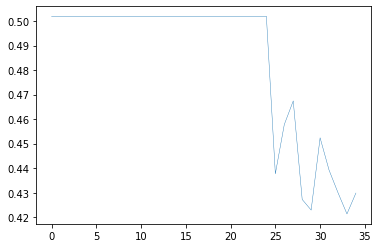

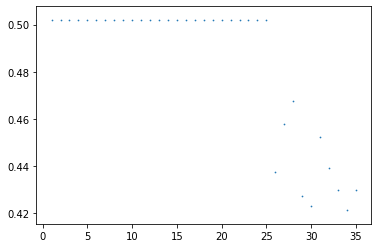

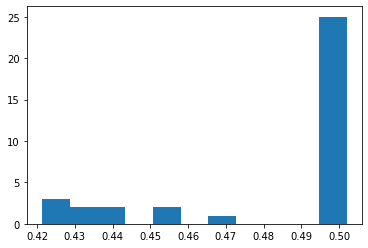

Average value is:  0.4838395
Total Predicted Positive:  25  out of  35
71.42857142857143 %
Epoch:  2
Train on 1 samples, validate on 35 samples
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.6893 - acc: 1.0000 - val_loss: 0.7250 - val_acc: 0.7143
(35, 1)


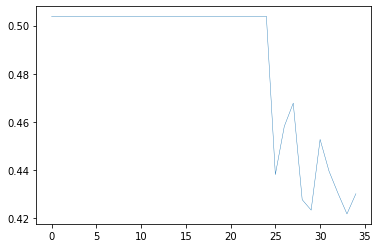

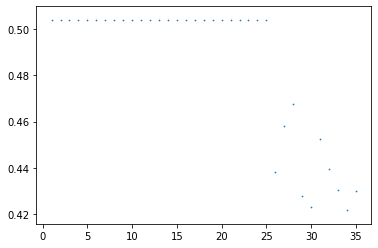

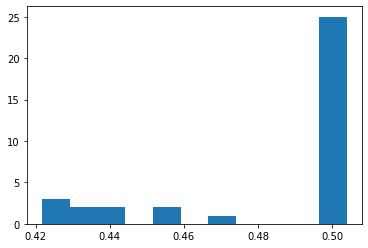

Average value is:  0.4853434
Total Predicted Positive:  25  out of  35
71.42857142857143 %
Epoch:  3
Train on 1 samples, validate on 35 samples
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.6854 - acc: 1.0000 - val_loss: 0.7219 - val_acc: 0.7143
(35, 1)


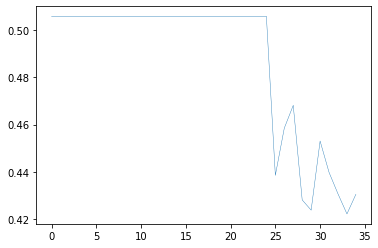

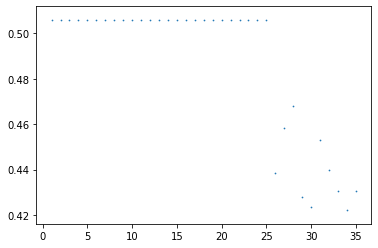

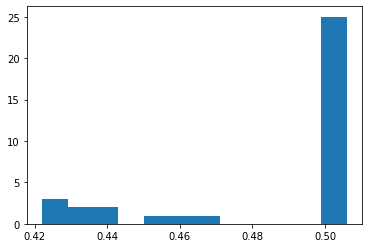

Average value is:  0.4868562
Total Predicted Positive:  25  out of  35
71.42857142857143 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## RNN Model 1
## create the model
modelRNNLSTM1 = 0
modelRNNLSTM1 = Sequential()
modelRNNLSTM1.add(cudnn_recurrent.CuDNNLSTM(units=2, input_shape=(flatten_value,3),return_sequences=True))
modelRNNLSTM1.add(cudnn_recurrent.CuDNNLSTM(units=2))
modelRNNLSTM1.add(Dense(1, activation='sigmoid'))
modelRNNLSTM1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelRNNLSTM1.build(flatten_shape) # `input_shape` is the shape of the input data

print(modelRNNLSTM1.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelRNNLSTM1.fit(X_train1_flatten, y_train1, epochs=1, batch_size=batch_size_user, validation_data = (X_val1_flatten, y_val1),verbose=1)

  # Test the model
  y_pred = modelRNNLSTM1.predict(X_val1_flatten)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_3 (CuDNNLSTM)     (None, 20000, 2)          56        
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 2)                 48        
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 3         
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 6 samples, validate on 30 samples
Epoch 1/1
6/6 [==============================] - 3s 452ms/step - loss: 0.6931 - acc: 0.0000e+00 - val_loss: 0.7353 - val_acc: 0.6667
(30, 1)


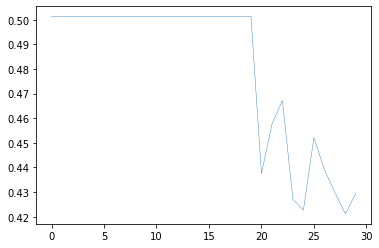

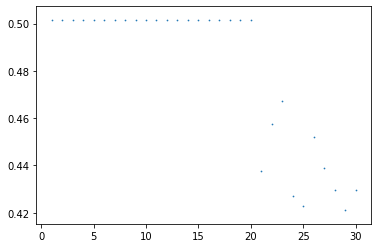

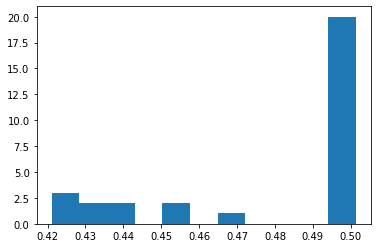

Average value is:  0.48042104
Total Predicted Positive:  20  out of  30
66.66666666666666 %
Epoch:  2
Train on 6 samples, validate on 30 samples
Epoch 1/1
6/6 [==============================] - 1s 242ms/step - loss: 0.6903 - acc: 1.0000 - val_loss: 0.7328 - val_acc: 0.6667
(30, 1)


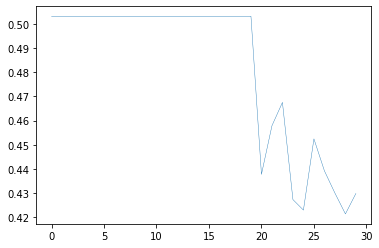

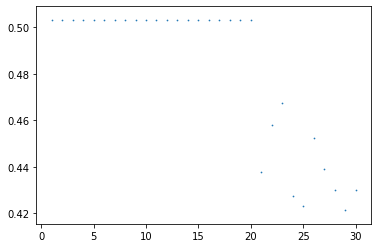

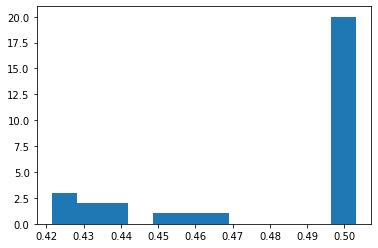

Average value is:  0.48164085
Total Predicted Positive:  20  out of  30
66.66666666666666 %
Epoch:  3
Train on 6 samples, validate on 30 samples
Epoch 1/1
6/6 [==============================] - 1s 240ms/step - loss: 0.6869 - acc: 1.0000 - val_loss: 0.7302 - val_acc: 0.6667
(30, 1)


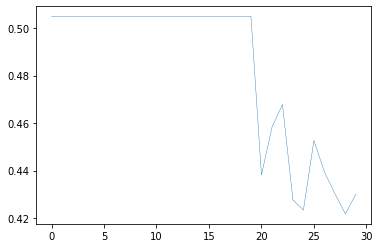

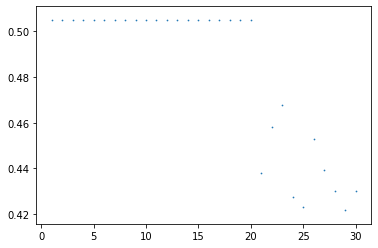

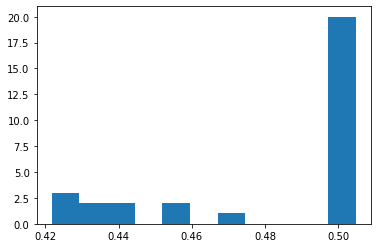

Average value is:  0.48293886
Total Predicted Positive:  20  out of  30
66.66666666666666 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## RNN Model 2
## create the model
modelRNNLSTM2 = 0
modelRNNLSTM2 = Sequential()
modelRNNLSTM2.add(cudnn_recurrent.CuDNNLSTM(units=2, input_shape=(flatten_value,3),return_sequences=True))
modelRNNLSTM2.add(cudnn_recurrent.CuDNNLSTM(units=2))
modelRNNLSTM2.add(Dense(1, activation='sigmoid'))
modelRNNLSTM2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelRNNLSTM2.build(flatten_shape) # `input_shape` is the shape of the input data

print(modelRNNLSTM2.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelRNNLSTM2.fit(X_train2_flatten, y_train2, epochs=1, batch_size=batch_size_user, validation_data = (X_val2_flatten, y_val2),verbose=1)

  # Test the model
  y_pred = modelRNNLSTM2.predict(X_val2_flatten)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_5 (CuDNNLSTM)     (None, 20000, 2)          56        
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (None, 2)                 48        
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 3         
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 12 samples, validate on 24 samples
Epoch 1/1
12/12 [==============================] - 3s 234ms/step - loss: 0.6931 - acc: 0.0000e+00 - val_loss: 0.7457 - val_acc: 0.5833
(24, 1)


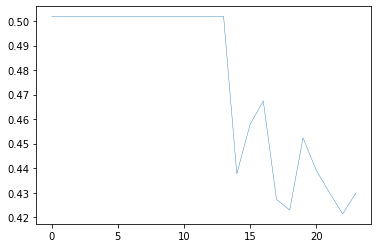

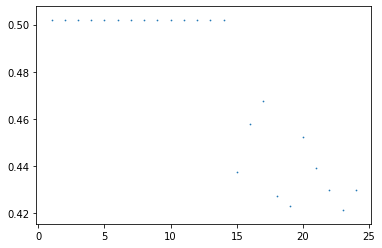

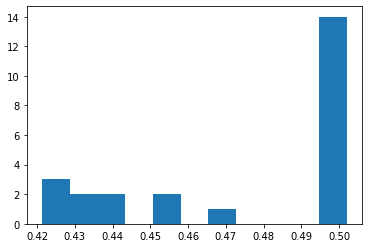

Average value is:  0.4755421
Total Predicted Positive:  14  out of  24
58.333333333333336 %
Epoch:  2
Train on 12 samples, validate on 24 samples
Epoch 1/1
12/12 [==============================] - 1s 116ms/step - loss: 0.6893 - acc: 1.0000 - val_loss: 0.7431 - val_acc: 0.5833
(24, 1)


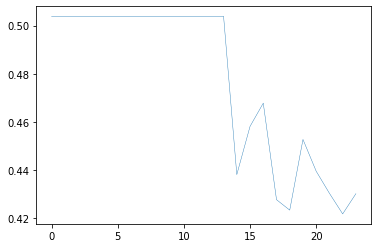

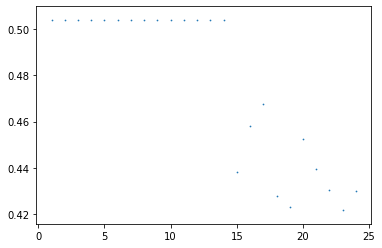

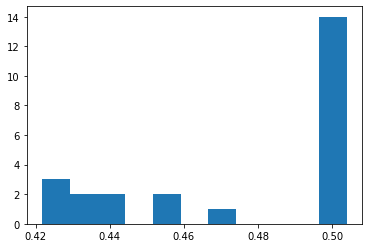

Average value is:  0.476835
Total Predicted Positive:  14  out of  24
58.333333333333336 %
Epoch:  3
Train on 12 samples, validate on 24 samples
Epoch 1/1
12/12 [==============================] - 1s 119ms/step - loss: 0.6854 - acc: 1.0000 - val_loss: 0.7405 - val_acc: 0.5833
(24, 1)


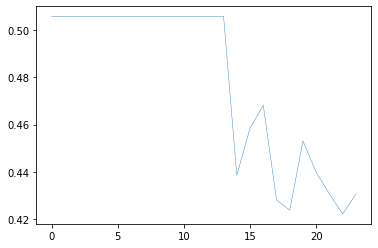

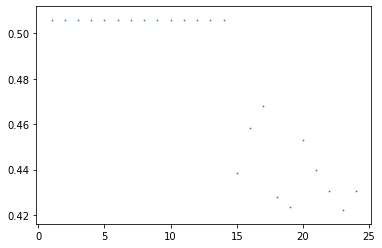

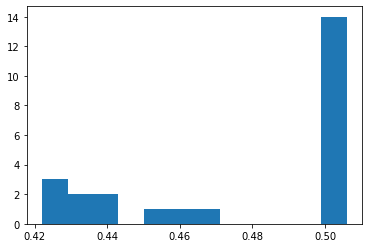

Average value is:  0.47812948
Total Predicted Positive:  14  out of  24
58.333333333333336 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## RNN Model 3
## create the model
modelRNNLSTM3 = 0
modelRNNLSTM3 = Sequential()
modelRNNLSTM3.add(cudnn_recurrent.CuDNNLSTM(units=2, input_shape=(flatten_value,3),return_sequences=True))
modelRNNLSTM3.add(cudnn_recurrent.CuDNNLSTM(units=2))
modelRNNLSTM3.add(Dense(1, activation='sigmoid'))
modelRNNLSTM3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelRNNLSTM3.build(flatten_shape) # `input_shape` is the shape of the input data

print(modelRNNLSTM3.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelRNNLSTM3.fit(X_train3_flatten, y_train3, epochs=1, batch_size=batch_size_user, validation_data = (X_val3_flatten, y_val3),verbose=1)

  # Test the model
  y_pred = modelRNNLSTM3.predict(X_val3_flatten)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_7 (CuDNNLSTM)     (None, 20000, 2)          56        
_________________________________________________________________
cu_dnnlstm_8 (CuDNNLSTM)     (None, 2)                 48        
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 3         
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 18 samples, validate on 18 samples
Epoch 1/1
18/18 [==============================] - 3s 168ms/step - loss: 0.6931 - acc: 0.0000e+00 - val_loss: 0.7646 - val_acc: 0.4444
(18, 1)


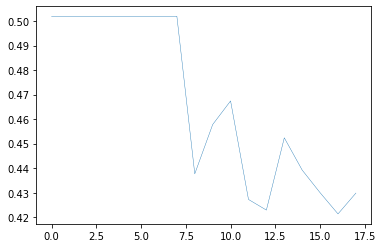

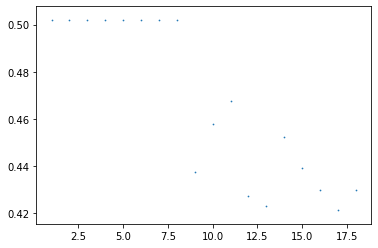

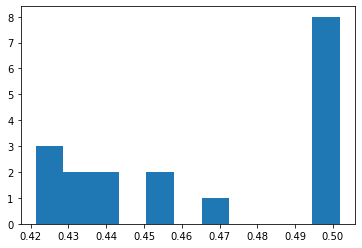

Average value is:  0.46674183
Total Predicted Positive:  9  out of  18
50.0 %
Epoch:  2
Train on 18 samples, validate on 18 samples
Epoch 1/1
18/18 [==============================] - 2s 90ms/step - loss: 0.6893 - acc: 1.0000 - val_loss: 0.7624 - val_acc: 0.4444
(18, 1)


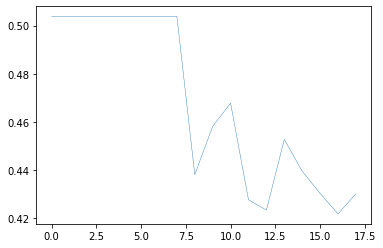

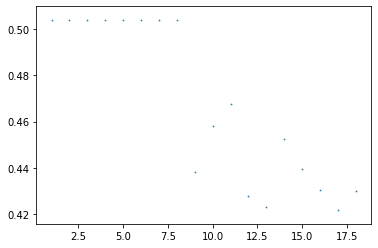

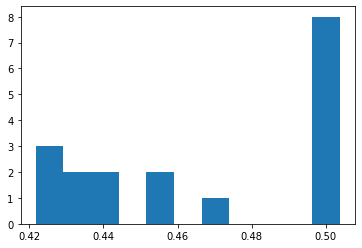

Average value is:  0.46781096
Total Predicted Positive:  8  out of  18
44.44444444444444 %
Epoch:  3
Train on 18 samples, validate on 18 samples
Epoch 1/1
18/18 [==============================] - 2s 84ms/step - loss: 0.6854 - acc: 1.0000 - val_loss: 0.7602 - val_acc: 0.4444
(18, 1)


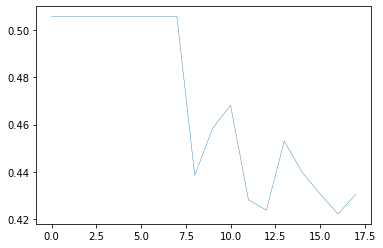

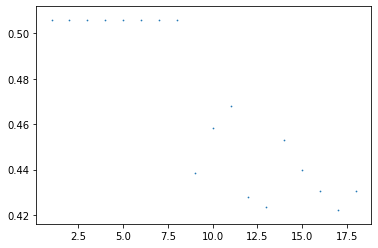

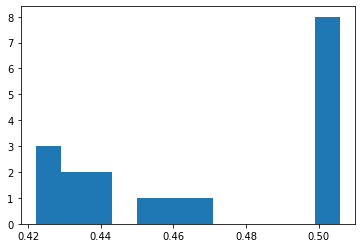

Average value is:  0.46887386
Total Predicted Positive:  8  out of  18
44.44444444444444 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## RNN Model 4
## create the model
modelRNNLSTM4 = 0
modelRNNLSTM4 = Sequential()
modelRNNLSTM4.add(cudnn_recurrent.CuDNNLSTM(units=2, input_shape=(flatten_value,3),return_sequences=True))
modelRNNLSTM4.add(cudnn_recurrent.CuDNNLSTM(units=2))
modelRNNLSTM4.add(Dense(1, activation='sigmoid'))
modelRNNLSTM4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelRNNLSTM4.build(flatten_shape) # `input_shape` is the shape of the input data

print(modelRNNLSTM4.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelRNNLSTM4.fit(X_train4_flatten, y_train4, epochs=1, batch_size=batch_size_user, validation_data = (X_val4_flatten, y_val4),verbose=1)

  # Test the model
  y_pred = modelRNNLSTM4.predict(X_val4_flatten)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_9 (CuDNNLSTM)     (None, 20000, 2)          56        
_________________________________________________________________
cu_dnnlstm_10 (CuDNNLSTM)    (None, 2)                 48        
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 3         
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 24 samples, validate on 12 samples
Epoch 1/1
24/24 [==============================] - 3s 132ms/step - loss: 0.6931 - acc: 0.0000e+00 - val_loss: 0.8028 - val_acc: 0.1667
(12, 1)


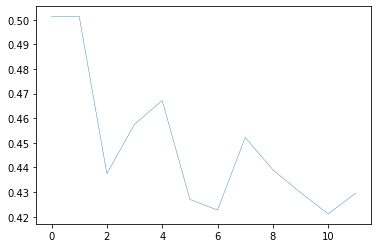

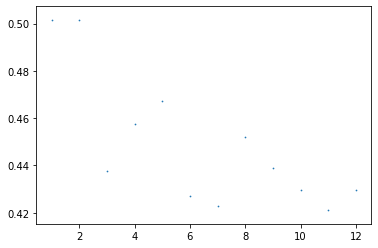

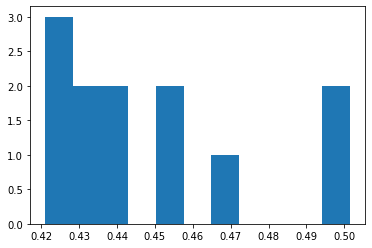

Average value is:  0.44888356
Total Predicted Positive:  5  out of  12
41.66666666666667 %
Epoch:  2
Train on 24 samples, validate on 12 samples
Epoch 1/1
24/24 [==============================] - 1s 62ms/step - loss: 0.6903 - acc: 1.0000 - val_loss: 0.8016 - val_acc: 0.1667
(12, 1)


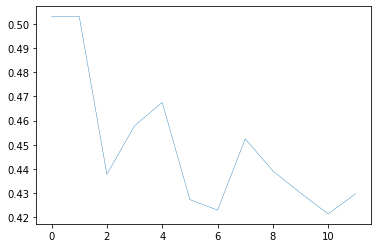

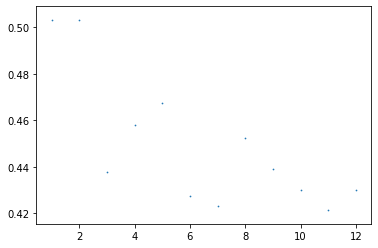

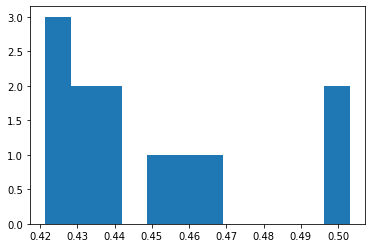

Average value is:  0.44940886
Total Predicted Positive:  5  out of  12
41.66666666666667 %
Epoch:  3
Train on 24 samples, validate on 12 samples
Epoch 1/1
24/24 [==============================] - 1s 61ms/step - loss: 0.6869 - acc: 1.0000 - val_loss: 0.8005 - val_acc: 0.1667
(12, 1)


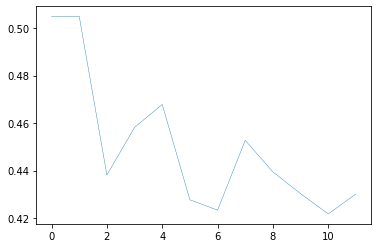

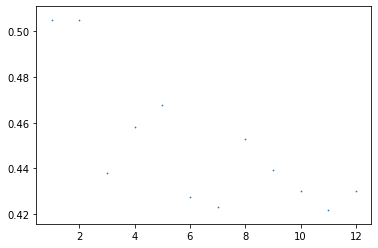

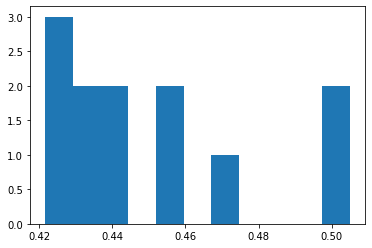

Average value is:  0.44994912
Total Predicted Positive:  5  out of  12
41.66666666666667 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## RNN Model 5
## create the model
modelRNNLSTM5 = 0
modelRNNLSTM5 = Sequential()
modelRNNLSTM5.add(cudnn_recurrent.CuDNNLSTM(units=2, input_shape=(flatten_value,3),return_sequences=True))
modelRNNLSTM5.add(cudnn_recurrent.CuDNNLSTM(units=2))
modelRNNLSTM5.add(Dense(1, activation='sigmoid'))
modelRNNLSTM5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelRNNLSTM5.build(flatten_shape) # `input_shape` is the shape of the input data

print(modelRNNLSTM5.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelRNNLSTM5.fit(X_train5_flatten, y_train5, epochs=1, batch_size=batch_size_user, validation_data = (X_val5_flatten, y_val5),verbose=1)

  # Test the model
  y_pred = modelRNNLSTM5.predict(X_val5_flatten)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_11 (CuDNNLSTM)    (None, 20000, 2)          56        
_________________________________________________________________
cu_dnnlstm_12 (CuDNNLSTM)    (None, 2)                 48        
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 3         
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 30 samples, validate on 6 samples
Epoch 1/1
30/30 [==============================] - 3s 112ms/step - loss: 0.7083 - acc: 0.0000e+00 - val_loss: 0.8355 - val_acc: 0.0000e+00
(6, 1)


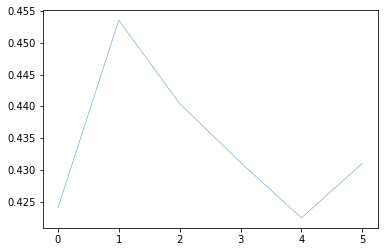

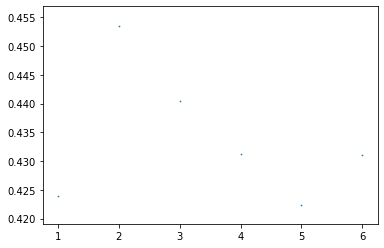

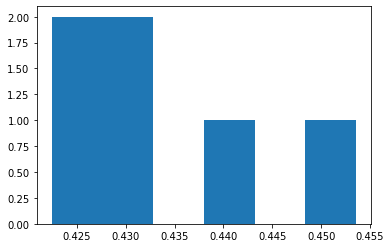

Average value is:  0.433781
Total Predicted Positive:  2  out of  6
33.33333333333333 %
Epoch:  2
Train on 30 samples, validate on 6 samples
Epoch 1/1
30/30 [==============================] - 1s 48ms/step - loss: 0.7043 - acc: 0.8667 - val_loss: 0.8310 - val_acc: 0.0000e+00
(6, 1)


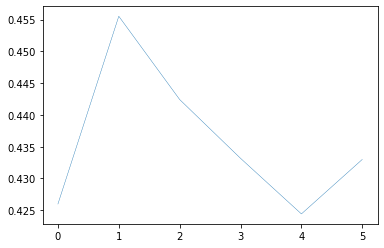

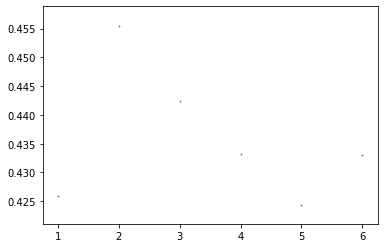

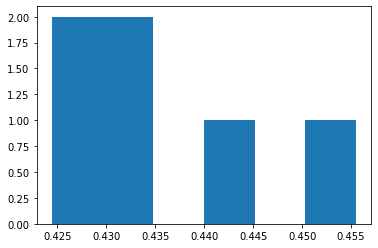

Average value is:  0.43574885
Total Predicted Positive:  2  out of  6
33.33333333333333 %
Epoch:  3
Train on 30 samples, validate on 6 samples
Epoch 1/1
30/30 [==============================] - 1s 48ms/step - loss: 0.7005 - acc: 0.8667 - val_loss: 0.8265 - val_acc: 0.0000e+00
(6, 1)


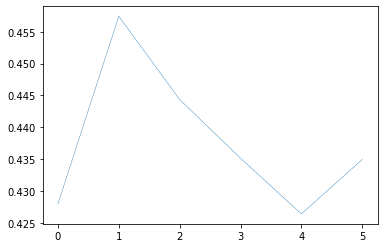

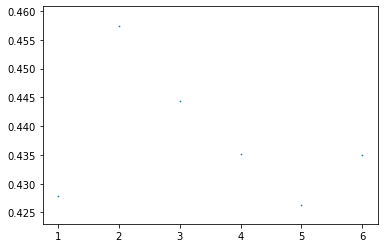

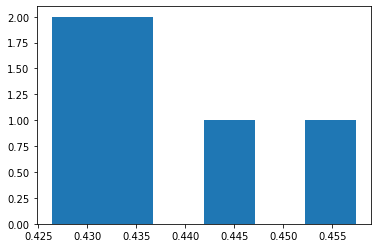

Average value is:  0.43769965
Total Predicted Positive:  2  out of  6
33.33333333333333 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## RNN Model 6
## create the model
modelRNNLSTM6 = 0
modelRNNLSTM6 = Sequential()
modelRNNLSTM6.add(cudnn_recurrent.CuDNNLSTM(units=2, input_shape=(flatten_value,3),return_sequences=True))
modelRNNLSTM6.add(cudnn_recurrent.CuDNNLSTM(units=2))
modelRNNLSTM6.add(Dense(1, activation='sigmoid'))
modelRNNLSTM6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelRNNLSTM6.build(flatten_shape) # `input_shape` is the shape of the input data

print(modelRNNLSTM6.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelRNNLSTM6.fit(X_train6_flatten, y_train6, epochs=1, batch_size=batch_size_user, validation_data = (X_val6_flatten, y_val6),verbose=1)

  # Test the model
  y_pred = modelRNNLSTM6.predict(X_val6_flatten)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_13 (CuDNNLSTM)    (None, 20000, 2)          56        
_________________________________________________________________
cu_dnnlstm_14 (CuDNNLSTM)    (None, 2)                 48        
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 3         
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 2 samples, validate on 34 samples
Epoch 1/1
2/2 [==============================] - 3s 2s/step - loss: 0.8563 - acc: 0.0000e+00 - val_loss: 0.7204 - val_acc: 0.7647
(34, 1)


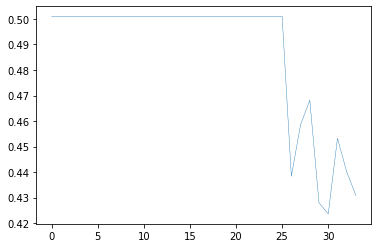

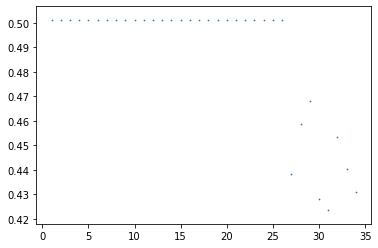

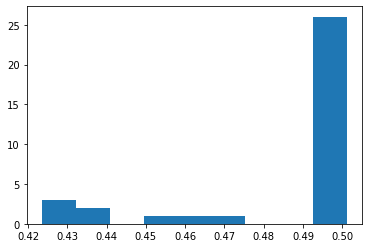

Average value is:  0.4872993
Total Predicted Positive:  26  out of  34
76.47058823529412 %
Epoch:  2
Train on 2 samples, validate on 34 samples
Epoch 1/1
2/2 [==============================] - 1s 702ms/step - loss: 0.8525 - acc: 0.0000e+00 - val_loss: 0.7176 - val_acc: 0.7647
(34, 1)


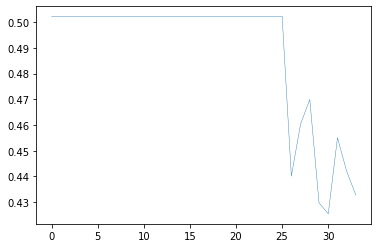

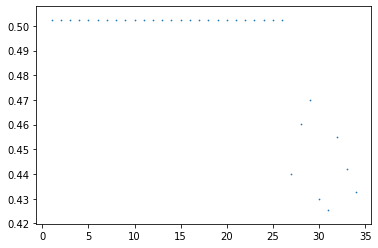

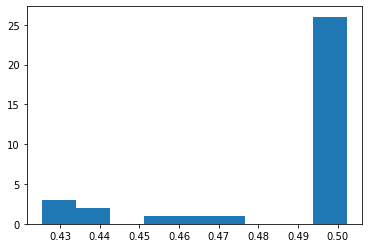

Average value is:  0.48864785
Total Predicted Positive:  26  out of  34
76.47058823529412 %
Epoch:  3
Train on 2 samples, validate on 34 samples
Epoch 1/1
2/2 [==============================] - 1s 701ms/step - loss: 0.8482 - acc: 0.0000e+00 - val_loss: 0.7146 - val_acc: 0.7647
(34, 1)


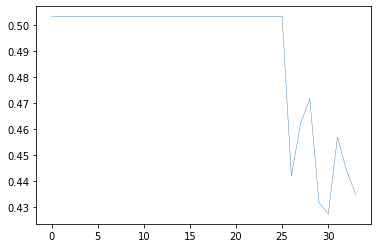

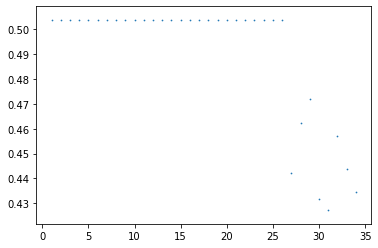

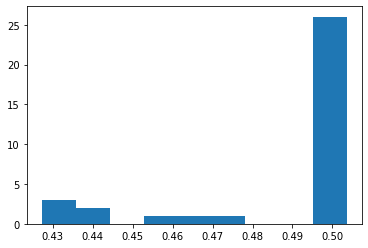

Average value is:  0.49006462
Total Predicted Positive:  26  out of  34
76.47058823529412 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## RNN Model 7
## create the model
modelRNNLSTM7 = 0
modelRNNLSTM7 = Sequential()
modelRNNLSTM7.add(cudnn_recurrent.CuDNNLSTM(units=2, input_shape=(flatten_value,3),return_sequences=True))
modelRNNLSTM7.add(cudnn_recurrent.CuDNNLSTM(units=2))
modelRNNLSTM7.add(Dense(1, activation='sigmoid'))
modelRNNLSTM7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelRNNLSTM7.build(flatten_shape) # `input_shape` is the shape of the input data

print(modelRNNLSTM7.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelRNNLSTM7.fit(X_train7_flatten, y_train7, epochs=1, batch_size=batch_size_user, validation_data = (X_val7_flatten, y_val7),verbose=1)

  # Test the model
  y_pred = modelRNNLSTM7.predict(X_val7_flatten)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1